# Import

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANN Competition/Homework2/Marco

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1ckveNGqgPJLZP8oVcHRvQStV1LtkEwq1/ANN Competition/Homework2/Marco


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import keras.backend as K
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

# Data Inspection


In [ ]:
import zipfile

dataset = np.load('dataset/training_data.npy', allow_pickle=False)
categories = np.load('dataset/categories.npy', allow_pickle=False)
valid_periods = np.load('dataset/valid_periods.npy', allow_pickle=False)

dataset_df = pd.DataFrame(dataset)
categories_df = pd.DataFrame(categories)
valid_periods_df = pd.DataFrame(valid_periods)

print('dataset size:',str(dataset_df.shape) , '\nCategories size:', str(categories_df.shape) ,'\nvalid_periods size:', str(valid_periods_df.shape))


dataset size: (48000, 2776) 
Categories size: (48000, 1) 
valid_periods size: (48000, 2)


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [ ]:
dataset_df = dataset_df.astype(np.float32)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


In [ ]:
valid_periods_df[0].info

<bound method Series.info of 0        2325
1        2325
2        2325
3        2712
4        2682
         ... 
47995    2642
47996    2642
47997    2676
47998    2676
47999    2676
Name: 0, Length: 48000, dtype: int64>

In [ ]:
data_percentage_to_crop = 0
index = 0
while data_percentage_to_crop < 1:
  count = (valid_periods_df[0] < index).sum()
  data_percentage_to_crop = (count / dataset_df.shape[0]) * 100
  index += 50

print(count, index)

496 2200


In [ ]:
new_dataset_df = dataset_df.iloc[:, 2200:]

new_dataset_df.shape

(48000, 576)

In [ ]:
new_dataset_df['category'] = categories_df

In [ ]:
mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}

new_dataset_df['category'] = new_dataset_df['category'].map(mapping)

In [ ]:
new_dataset_df.head()

2200  2201  2202  2203  2204  2205  2206  2207  2208  2209  ...      2767  \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.412963   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.624000   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.949098   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.307030   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.522727   

       2768      2769      2770      2771      2772      2773      2774  \
0  0.501852  0.756481  0.744444  0.640741  0.516667  0.602778  0.367593   
1  0.644000  0.688000  0.740000  0.640000  0.536000  0.600000  0.460000   
2  0.919297  0.916705  0.901249  0.932531  0.955206  0.960481  0.946506   
3  0.325681  0.361549  0.430416  0.486370  0.450502  0.470588  0.569584   
4  0.568182  0.772727  0.681818  0.704545  0.863636  0.727273  0.818182   

       2775  category  
0  0.331481         3  
1  0.396000         3  
2  0.977140         3  
3  0.571019         3  
4  0.840909         3  

[5 rows x 577 columns]

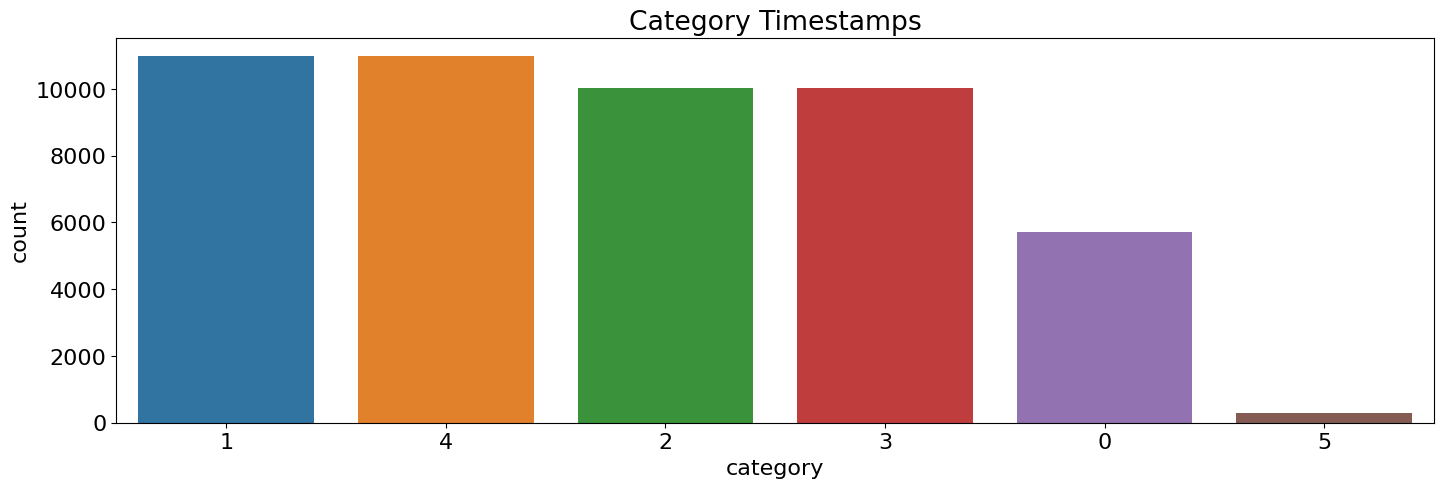

In [ ]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'category', data = new_dataset_df, order = new_dataset_df.category.value_counts().index)
plt.title('Category Timestamps')
plt.show()

In [ ]:
# Use pivot_table to reshape the DataFrame
pivot_df = new_dataset_df.pivot_table(columns='category', values=range(2200,2776), aggfunc='first')

# Reset the index if needed
pivot_df.reset_index(inplace=True)

# Display the result
print(pivot_df)

category  index         0         1         2         3         4         5
0          2200  0.000000  0.000000  0.000000  0.000000  0.000000  0.003019
1          2201  0.000000  0.000000  0.000000  0.000000  0.000000  0.002828
2          2202  0.000000  0.000000  0.000000  0.000000  0.000000  0.002874
3          2203  0.000000  0.000000  0.000000  0.000000  0.000000  0.003017
4          2204  0.000000  0.000000  0.000000  0.000000  0.000000  0.003047
..          ...       ...       ...       ...       ...       ...       ...
571        2771  0.594619  0.231812  0.553897  0.640741  0.718124  0.832093
572        2772  0.582063  0.184876  0.504146  0.516667  0.707796  0.853944
573        2773  0.548879  0.152542  0.427861  0.602778  0.716832  0.879423
574        2774  0.501345  0.176010  0.356551  0.367593  0.718477  0.903028
575        2775  0.640359  0.168970  0.388060  0.331481  0.728257  0.911195

[576 rows x 7 columns]


In [ ]:
new_dataset_df = new_dataset_df.T

In [ ]:
new_dataset_df.iloc[:-1, [1,2]]


1         2
2200  0.000  0.000000
2201  0.000  0.000000
2202  0.000  0.000000
2203  0.000  0.000000
2204  0.000  0.000000
...     ...       ...
2771  0.640  0.932531
2772  0.536  0.955206
2773  0.600  0.960481
2774  0.460  0.946506
2775  0.396  0.977140

[576 rows x 2 columns]

In [ ]:
print(np.array([new_dataset_df.loc['category'] == 5])[0])
new_dataset_df.iloc[:-1, np.array([new_dataset_df.loc['category'] == 4])[0]].T.reset_index(drop=True).T[range(3)]

[False False False ...  True  True  True]


0         1         2
2200  0.000000  0.000000  0.000000
2201  0.000000  0.000000  0.000000
2202  0.000000  0.000000  0.000000
2203  0.000000  0.000000  0.000000
2204  0.000000  0.000000  0.000000
...        ...       ...       ...
2771  0.718124  0.331911  0.151345
2772  0.707796  0.330827  0.155864
2773  0.716832  0.312071  0.149724
2774  0.718477  0.311569  0.146498
2775  0.728257  0.295287  0.122353

[576 rows x 3 columns]

In [ ]:
def inspect_category(category, df):
    data = df.iloc[:-1, np.array([df.loc['category'] == category])[0]].T.reset_index(drop=True).T[range(80,90)]
    axis = data.plot(subplots=True, figsize=(17, 9), title=category)
    for ax in axis:
        ax.legend(loc='lower right')

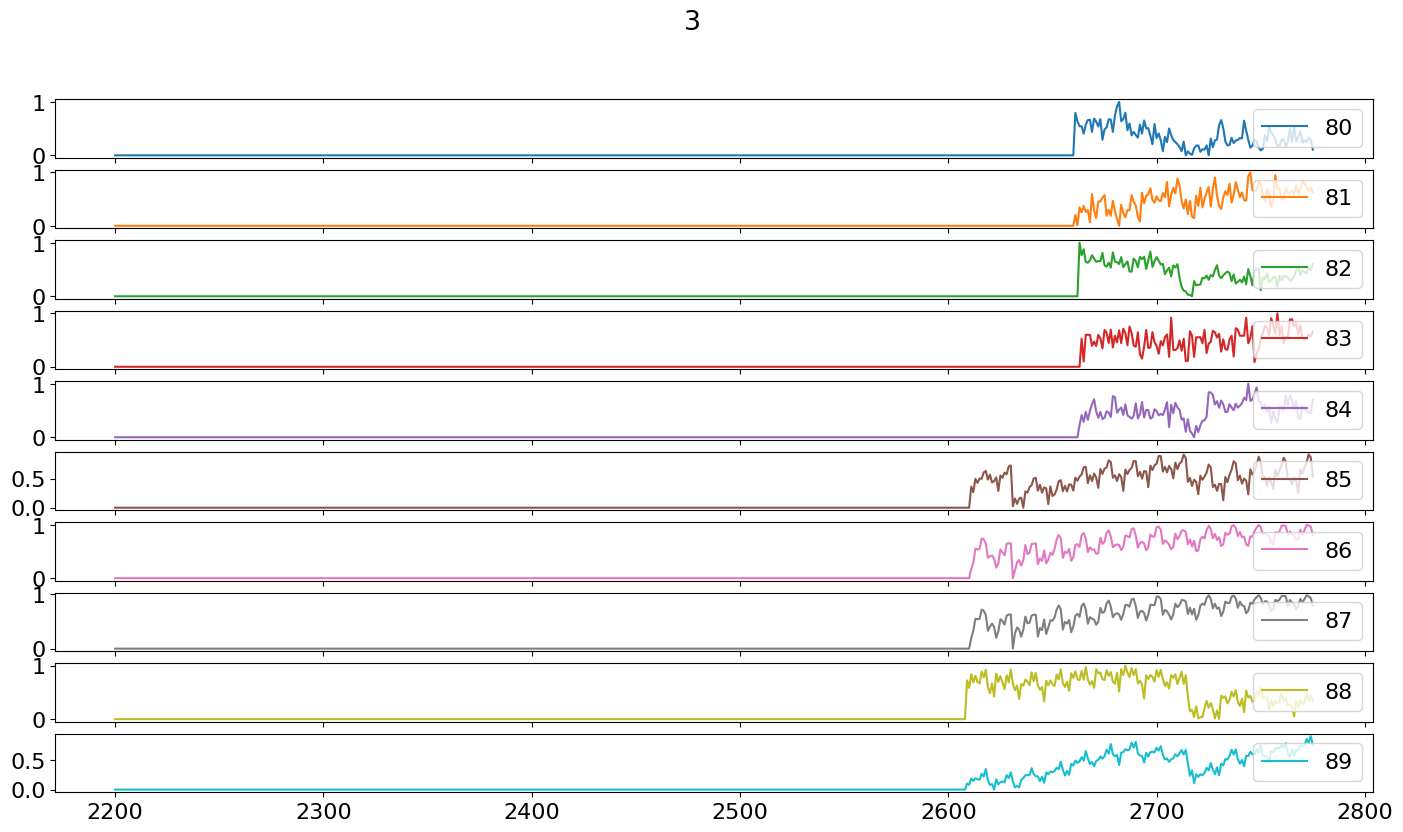

In [ ]:
inspect_category(3, new_dataset_df)

# Data Processing

In [ ]:
dataset = np.load('dataset/training_data.npy', allow_pickle=False)
categories = np.load('dataset/categories.npy', allow_pickle=False)
valid_periods = np.load('dataset/valid_periods.npy', allow_pickle=False)

In [ ]:
#define a new dataframe containing: valid 200 time steps sequence, category of the sequence, 18 time steps sequence label
def build_dataset(window, stride, lab_len):
  new_categories = []
  new_sequences = []
  new_labels = []
  for i, valid in enumerate(valid_periods):
    validsequence = dataset[i,valid[0]:valid[1]]

    # if the sequences are smaller than the window size (+ the length of the label)
    # we pad them and put them in the dataset

    if validsequence.shape[0]<(window+lab_len):
      pad = np.zeros((window+lab_len)-validsequence.shape[0])
      validsequence = np.concatenate([pad, validsequence])
      new_sequences.append(validsequence[:window])
      new_labels.append(validsequence[window:])
      new_categories.append(categories[i])

    # if the sequences are larger than window, we calculate how many strides
    # we are able to make, if we need some padding to make one more stride we
    # insert it, then we separate the strided sequences and insert them in the dataset
    if validsequence.shape[0]>(window+lab_len):

      remain = (validsequence.shape[0]-lab_len-window)%stride
      if remain != 0:
        pad = np.zeros(stride-remain)
        validsequence = np.concatenate([pad, validsequence])
        sub_num = (int)((validsequence.shape[0]-lab_len-window)/stride)
        for j in range(0, sub_num+1):
          new_sequences.append(validsequence[(j*stride):(j*stride+window)])
          new_labels.append(validsequence[(j*stride+window):(j*stride+window+lab_len)])
          new_categories.append(categories[i])
      else:
        sub_num = (int)((validsequence.shape[0]-lab_len-window)/stride)
        for j in range(0, sub_num+1):
          new_sequences.append(validsequence[(j*stride):(j*stride+window)])
          new_labels.append(validsequence[(j*stride+window):(j*stride+window+lab_len)])
          new_categories.append(categories[i])

  print(str(len(new_sequences)) + " " + str(len(new_labels)) + " " + str(len(new_categories)))
  return np.array(new_sequences), np.array(new_labels), np.array(new_categories)

X, y, cat = build_dataset(200, 2, 9)

print(X.shape)
print(y.shape)

1217662 1217662 1217662
(1217662, 200)
(1217662, 9)


In [ ]:
print(np.unique(cat))

['A' 'B' 'C' 'D' 'E' 'F']


In [ ]:
XA, yA = [], []
XB, yB = [], []
XC, yC = [], []
XD, yD = [], []
XE, yE = [], []
XF, yF = [], []

for i,seq in enumerate(X):
  if cat[i] == 'A':
    XA.append(seq)
    yA.append(y[i])
  elif cat[i] == 'B':
    XB.append(seq)
    yB.append(y[i])
  elif cat[i] == 'C':
    XC.append(seq)
    yC.append(y[i])
  elif cat[i] == 'D':
    XD.append(seq)
    yD.append(y[i])
  elif cat[i] == 'E':
    XE.append(seq)
    yE.append(y[i])
  elif cat[i] == 'F':
    XF.append(seq)
    yF.append(y[i])

XA = np.array(XA)
yA = np.array(yA)
XB = np.array(XB)
yB = np.array(yB)
XC = np.array(XC)
yC = np.array(yC)
XD = np.array(XD)
yD = np.array(yD)
XE = np.array(XE)
yE = np.array(yE)
XF = np.array(XF)
yF = np.array(yF)

print("A: " + str(len(XA)) + " B:" + str(len(XB)) + " C:" + str(len(XC)) + " D:" + str(len(XD)) + " E:" + str(len(XE)) + " F:" + str(len(XF)))

A: 243855 B:164133 C:259964 D:331783 E:211182 F:6745


In [ ]:
print(cat.shape)

(1217662,)


In [ ]:
input_shape = (X.shape[1], 1)
output_shape = (y.shape[1], 1)
batch_size = 32
epochs = 50

print(str(input_shape) + " " + str(output_shape))

(200, 1) (9, 1)


In [ ]:
cat, _ = pd.factorize(cat)
print(cat)

[0 0 0 ... 5 5 5]


In [ ]:
cat = tfk.utils.to_categorical(cat)
print(cat)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [ ]:
X_train, X_test, y_train, y_test, cat_train, cat_test = train_test_split(
    X,
    y,
    cat,
    test_size = 0.1,
    random_state=seed,
    stratify=cat,)

print(X_train.shape)
print(X_test.shape)

(1095895, 200)
(121767, 200)


# Data Processing 3

In [ ]:
import zipfile

dataset = np.load('dataset/training_data.npy', allow_pickle=False)
categories = np.load('dataset/categories.npy', allow_pickle=False)
valid_periods = np.load('dataset/valid_periods.npy', allow_pickle=False)

print('dataset size:',str(dataset.shape) , '\nCategories size:', str(categories.shape) ,'\nvalid_periods size:', str(valid_periods.shape))


dataset size: (48000, 2776) 
Categories size: (48000,) 
valid_periods size: (48000, 2)


In [ ]:
data = []
index = 0
for i in range(dataset.shape[0]):
  signal = dataset[i]
  valid = valid_periods[i]
  valid_signal = signal[valid_periods[i][0]:valid_periods[i][1]]
  data.append(valid_signal)
  index = index + 1

In [ ]:
X_train_raw, X_test_raw = train_test_split(
    data,
    test_size = 0.08,
    stratify=categories,
    random_state = seed
)
len(X_train_raw),len(X_test_raw)

(44160, 3840)

In [ ]:
window = 200
stride = 5
telescope = 9
direct_telescope = 9

In [ ]:
def build_sequences(df, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()


    for i in range(len(df)):

        if(len(temp_df[i]) <= window):
          padding_check = len(df[i])%window

          if(padding_check != 0):
              # Compute padding length
              padding_len = window - len(temp_df[i])%window
              padding = np.zeros((padding_len), dtype='float32')
              temp_df[i] = np.concatenate((padding, temp_df[i]), axis=0)
              assert len(temp_df[i]) % window == 0

          padding_len = telescope
          padding = np.zeros((padding_len), dtype='float32')
          temp_df[i] = np.concatenate((padding, temp_df[i]), axis = 0)
          dataset.append(temp_df[i][0:window])
          labels.append(temp_df[i][window:window+telescope]) # this notation is excluding the last of the range

        else:
          padding_check = len(df[i])%stride ###

          if(padding_check != 0):
              # Compute padding length
              padding_len = stride - len(temp_df[i])%stride
              padding = np.zeros((padding_len), dtype='float32')
              temp_df[i] = np.concatenate((padding, temp_df[i]), axis=0)
              assert len(temp_df[i]) % stride == 0


          padding = np.zeros((telescope), dtype='float32')
          temp_df[i] = np.concatenate((padding, temp_df[i]), axis=0)

          for idx in np.arange(0,len(temp_df[i])-window-telescope+1,stride):
             dataset.append(temp_df[i][idx:idx+window])
             labels.append(temp_df[i][idx+window:idx+window+telescope]) # this notation is excluding the last of the range

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(X_train_raw,window,stride,direct_telescope)
X_test, y_test =  build_sequences(X_test_raw,window,stride,direct_telescope)
input_shape = (200,1)
output_shape = (9,1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((516158, 200), (516158, 9), (46149, 200), (46149, 9))

# Data Processing 2

In [ ]:
import zipfile

dataset = np.load('dataset/training_data.npy', allow_pickle=False)
categories = np.load('dataset/categories.npy', allow_pickle=False)
valid_periods = np.load('dataset/valid_periods.npy', allow_pickle=False)

print('dataset size:',str(dataset.shape) , '\nCategories size:', str(categories.shape) ,'\nvalid_periods size:', str(valid_periods.shape))


dataset size: (48000, 2776) 
Categories size: (48000,) 
valid_periods size: (48000, 2)


In [ ]:
data = []
index = 0
for i in range(dataset.shape[0]):
  signal = dataset[i]
  valid = valid_periods[i]
  valid_signal = signal[valid_periods[i][0]:valid_periods[i][1]]
  data.append(valid_signal)
  index = index + 1
for d in data: print(d.shape)

Output streaming troncato alle ultime 5000 righe.
(684,)
(319,)
(46,)
(48,)
(60,)
(72,)
(96,)
(53,)
(46,)
(148,)
(47,)
(120,)
(119,)
(157,)
(157,)
(157,)
(157,)
(157,)
(64,)
(157,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(63,)
(64,)
(64,)
(64,)
(64,)
(57,)
(64,)
(64,)
(64,)
(64,)
(57,)
(64,)
(64,)
(57,)
(57,)
(64,)
(59,)
(64,)
(63,)
(64,)
(64,)
(157,)
(157,)
(64,)
(64,)
(64,)
(62,)
(64,)
(64,)
(64,)
(63,)
(64,)
(64,)
(59,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(157,)
(64,)
(64,)
(45,)
(64,)
(62,)
(157,)
(64,)
(64,)
(63,)
(63,)
(157,)
(157,)
(124,)
(125,)
(157,)
(133,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(73,)
(73,)
(73,)
(157,)
(157,)
(156,)
(149,)
(148,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)
(157,)


In [ ]:
X_train, X_test = train_test_split(
    data,
    test_size = 0.1,
    stratify=categories,
    random_state = seed
)
len(X_train),len(X_test)

(43200, 4800)

In [ ]:
window = 200
stride = 8
telescope = 18
direct_telescope = 9

In [ ]:
def build_sequences(df, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    padding_check = len(df)%window

    for i in range(len(df)):
        if(padding_check != 0):
            # Compute padding length
            padding_len = window - len(temp_df[i])%window
            padding = np.zeros((padding_len), dtype='float32')
            temp_df[i] = [padding, temp_df[i]]
            assert len(temp_df) % window == 0

        for idx in np.arange(0,len(temp_df[i])-window-telescope,stride):
            dataset.append(temp_df[i][idx:idx+window])
            labels.append(temp_df[i][idx+window:idx+window+telescope]) # this notation is excluding the last of the range

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
X_train, y_train = build_sequences(X_train,window,stride,direct_telescope)
X_test, y_test =  build_sequences(X_test,window,stride,direct_telescope)
input_shape = (200,1)
output_shape = (9,1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((266824, 200), (266824, 9), (30454, 200), (30454, 9))

# LSTM_V1

In [ ]:

def build_CONV_LSTM_model(input_shape, output_shape):
  input = tfkl.Input(shape=input_shape)

  lstm1 = tfkl.LSTM(256, return_sequences=True)(input)

  lstm2 = tfkl.LSTM(256, return_sequences=True)(lstm1)

  lstm3 = tfkl.LSTM(128)(lstm2)

  output = tfkl.Dense(output_shape[0], activation='sigmoid')(lstm3)

  model = tf.keras.Model(inputs=input, outputs=output, name='LSTM_V1')
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

  return model

Model: "LSTM_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 200, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 200, 256)          525312    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 18)                2322      
                                                                 
Total params: 988946 (3.77 MB)
Trainable params: 988946 (3.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


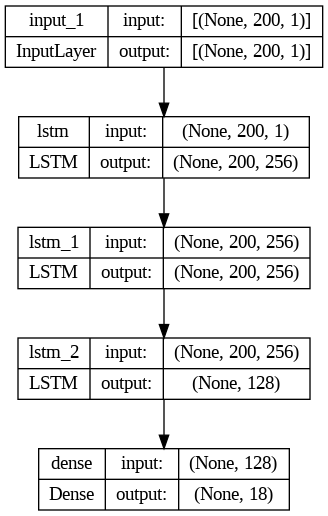

In [ ]:
model = build_CONV_LSTM_model(input_shape, output1_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/50
1335/1335 [==============================] - 80s 48ms/step - loss: 0.0186 - val_loss: 0.0229 - lr: 0.0010
Epoch 2/50
1335/1335 [==============================] - 61s 45ms/step - loss: 0.0150 - val_loss: 0.0214 - lr: 0.0010
Epoch 3/50
1335/1335 [==============================] - 61s 46ms/step - loss: 0.0138 - val_loss: 0.0211 - lr: 0.0010
Epoch 4/50
1335/1335 [==============================] - 64s 48ms/step - loss: 0.0132 - val_loss: 0.0195 - lr: 0.0010
Epoch 5/50
1335/1335 [==============================] - 61s 45ms/step - loss: 0.0126 - val_loss: 0.0194 - lr: 0.0010
Epoch 6/50
1335/1335 [==============================] - 61s 45ms/step - loss: 0.0122 - val_loss: 0.0193 - lr: 0.0010
Epoch 7/50
1335/1335 [==============================] - 61s 45ms/step - loss: 0.0117 - val_loss: 0.0194 - lr: 0.0010
Epoch 8/50
1335/1335 [==============================] - 61s 46ms/step - loss: 0.0114 - val_loss: 0.0194 - lr: 0.0010
Epoch 9/50
1335/1335 [==============================] - 61s 46ms

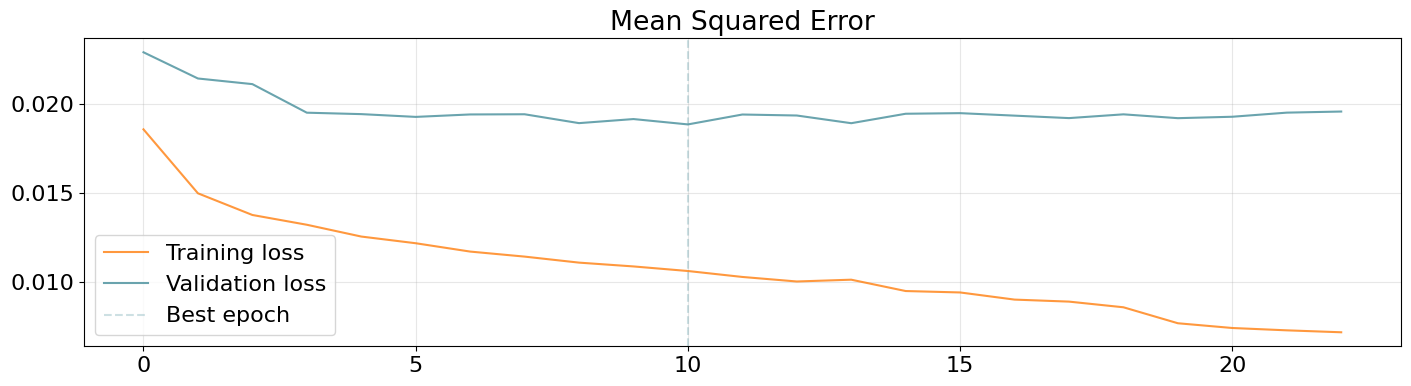

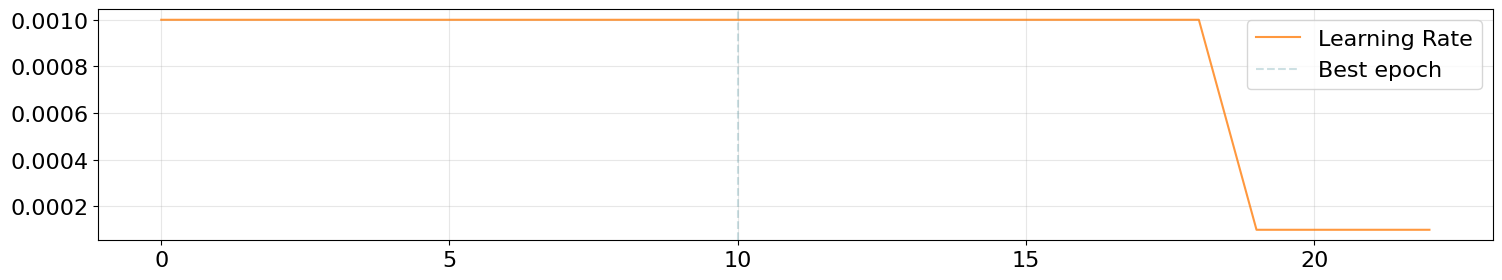

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# GRU_V1

In [ ]:

def build_model(input_shape, output_shape):
  input = tfkl.Input(shape=input_shape)

  lstm1 = tfkl.GRU(256, return_sequences=True)(input)

  lstm2 = tfkl.GRU(256, return_sequences=True)(lstm1)

  lstm3 = tfkl.GRU(128)(lstm2)

  output = tfkl.Dense(output_shape[0], activation='sigmoid')(lstm3)

  model = tf.keras.Model(inputs=input, outputs=output, name='GRU_V1')
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

  return model

Model: "GRU_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 gru (GRU)                   (None, 200, 256)          198912    
                                                                 
 gru_1 (GRU)                 (None, 200, 256)          394752    
                                                                 
 gru_2 (GRU)                 (None, 128)               148224    
                                                                 
 dense_2 (Dense)             (None, 18)                2322      
                                                                 
Total params: 744210 (2.84 MB)
Trainable params: 744210 (2.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


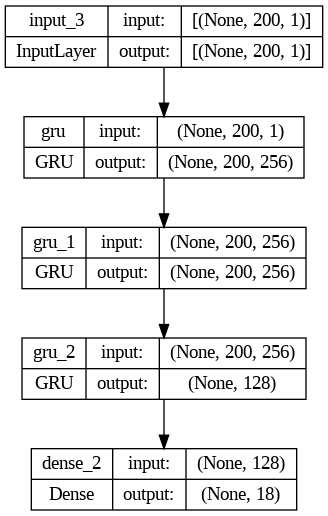

In [ ]:
model = build_model(input_shape, output1_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/50
1335/1335 [==============================] - 66s 41ms/step - loss: 0.0172 - val_loss: 0.0223 - lr: 0.0010
Epoch 2/50
1335/1335 [==============================] - 53s 40ms/step - loss: 0.0140 - val_loss: 0.0202 - lr: 0.0010
Epoch 3/50
1335/1335 [==============================] - 54s 40ms/step - loss: 0.0129 - val_loss: 0.0191 - lr: 0.0010
Epoch 4/50
1335/1335 [==============================] - 54s 40ms/step - loss: 0.0123 - val_loss: 0.0190 - lr: 0.0010
Epoch 5/50
1335/1335 [==============================] - 54s 41ms/step - loss: 0.0118 - val_loss: 0.0193 - lr: 0.0010
Epoch 6/50
1335/1335 [==============================] - 54s 41ms/step - loss: 0.0115 - val_loss: 0.0189 - lr: 0.0010
Epoch 7/50
1335/1335 [==============================] - 54s 41ms/step - loss: 0.0111 - val_loss: 0.0193 - lr: 0.0010
Epoch 8/50
1335/1335 [==============================] - 55s 41ms/step - loss: 0.0108 - val_loss: 0.0191 - lr: 0.0010
Epoch 9/50
1335/1335 [==============================] - 55s 41ms

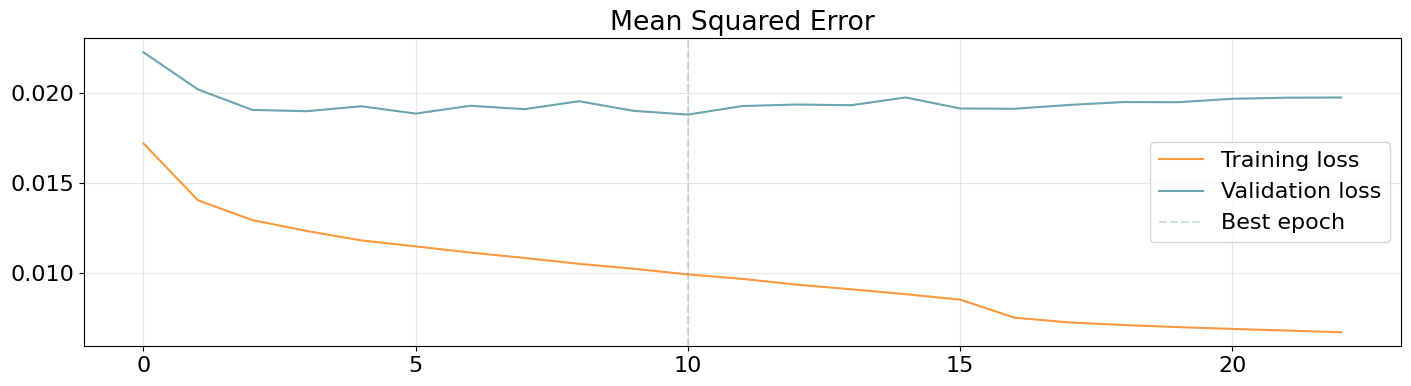

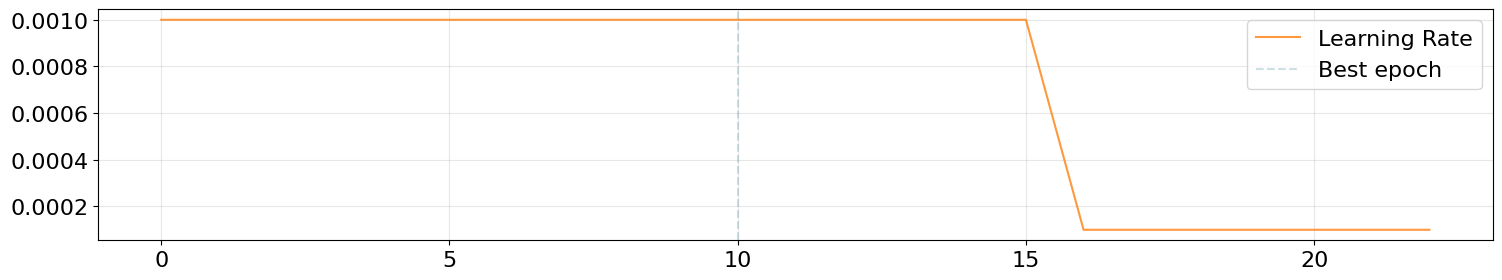

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Categorization Model: CAT_V1

In [ ]:
print(y_Bal[:10])
y_Bal, _ = pd.factorize(y_Bal)
y_Bal = tfk.utils.to_categorical(y_Bal)
print(y_Bal.shape)

['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
(27937, 6)


In [ ]:
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(
    pd.DataFrame(X_Bal),
    pd.DataFrame(y_Bal),
    test_size = 0.1,
    random_state=seed,
    stratify=y_Bal,)

In [ ]:
def build_model(input_shape, output1_shape, output2_shape):
  input = tfkl.Input(shape=input_shape)

  #category predictor
  C = tfkl.GRU(250, return_sequences=True)(input)
  C = tfkl.Dropout(0.3)(C)
  C = tfkl.GRU(250)(C)
  C = tfkl.Dropout(0.3)(C)

  C = tfkl.Dense(100, activation='relu')(C)
  C = tfkl.Dropout(0.3)(C)
  C = tfkl.Dense(80, activation='relu')(C)
  C = tfkl.Dropout(0.3)(C)
  output = tfkl.Dense(output2_shape, activation='softmax')(C)

  model = tf.keras.Model(inputs=input, outputs=output, name='CAT_V1')
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

Model: "CAT_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 gru (GRU)                   (None, 200, 200)          121800    
                                                                 
 dropout (Dropout)           (None, 200, 200)          0         
                                                                 
 gru_1 (GRU)                 (None, 200)               241200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0    

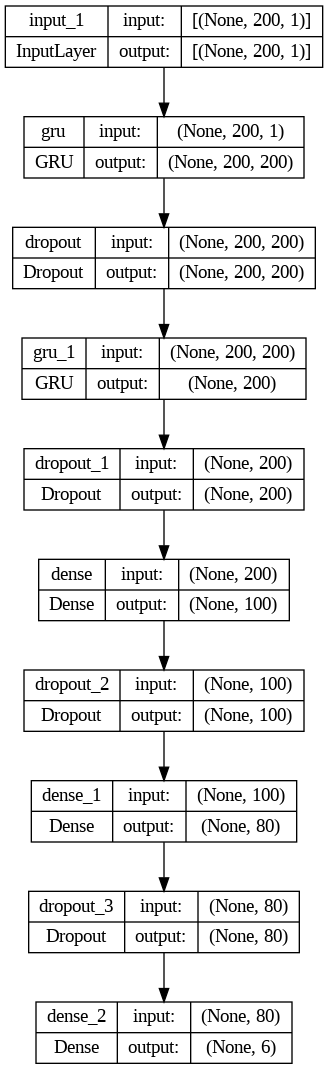

In [ ]:
model = build_model(input_shape, output1_shape, output2_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    X_bal_train,
    y_bal_train,
    batch_size = 16,
    epochs = 100,
    validation_data=(X_bal_val, y_bal_val),
    shuffle=True,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.3, min_lr=1e-5)
    ]
).history

Epoch 1/100
1572/1572 [==============================] - 43s 22ms/step - loss: 1.4930 - accuracy: 0.3399 - val_loss: 1.1933 - val_accuracy: 0.4689 - lr: 0.0010
Epoch 2/100
1572/1572 [==============================] - 31s 20ms/step - loss: 1.1474 - accuracy: 0.5109 - val_loss: 1.1225 - val_accuracy: 0.5293 - lr: 0.0010
Epoch 3/100
1572/1572 [==============================] - 32s 20ms/step - loss: 1.2950 - accuracy: 0.4360 - val_loss: 1.1456 - val_accuracy: 0.4914 - lr: 0.0010
Epoch 4/100
1572/1572 [==============================] - 32s 21ms/step - loss: 1.1653 - accuracy: 0.5002 - val_loss: 1.0786 - val_accuracy: 0.5426 - lr: 0.0010
Epoch 5/100
1572/1572 [==============================] - 31s 20ms/step - loss: 1.0918 - accuracy: 0.5394 - val_loss: 1.0545 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 6/100
1572/1572 [==============================] - 32s 20ms/step - loss: 1.0603 - accuracy: 0.5580 - val_loss: 0.9990 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 7/100
1572/1572 [=================

In [ ]:
model.save('Models//'+model.name)

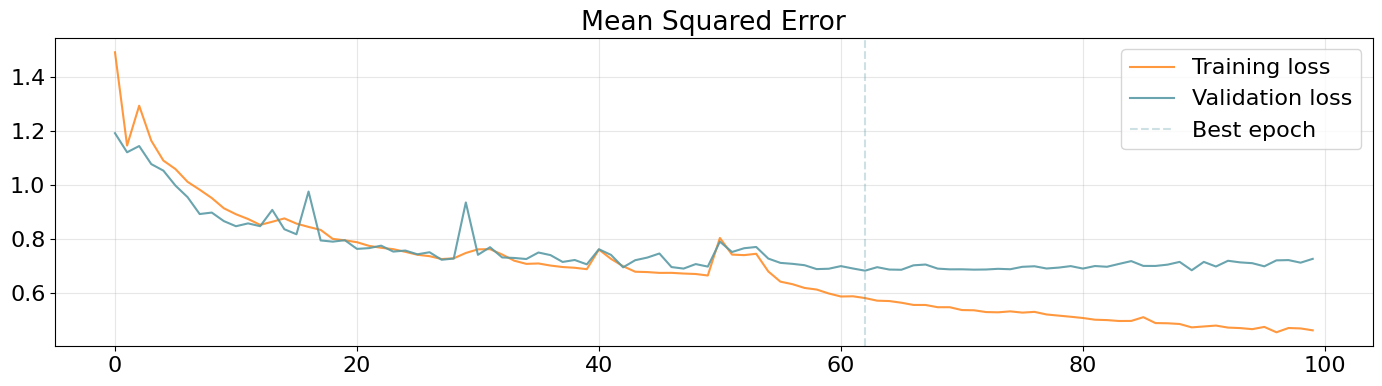

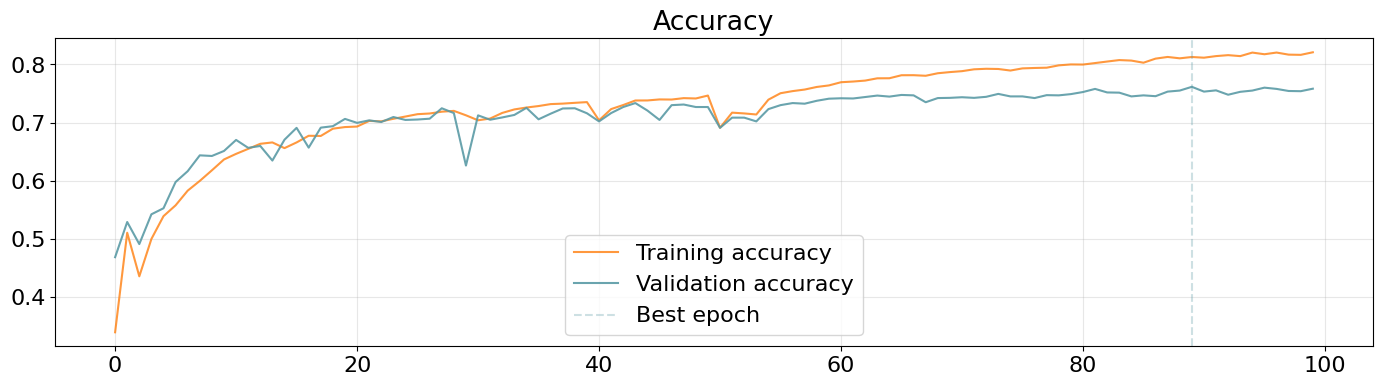

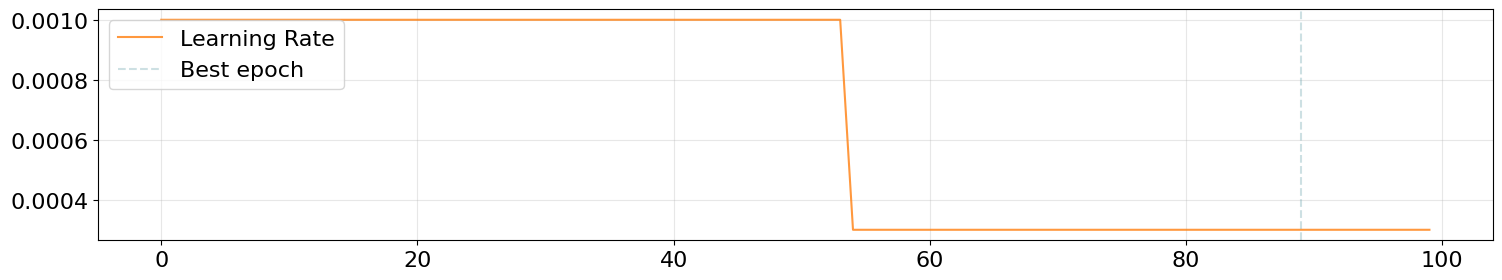

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
label_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_bal_val, verbose=0)
predictions.shape

(2794, 6)

[0.0000000e+00 1.9743326e-20 2.2323477e-17 2.1501061e-17 1.0000000e+00
 7.2693567e-18]
(2794,)
Accuracy: 0.7584
Precision: 0.7798
Recall: 0.7744
F1: 0.7762


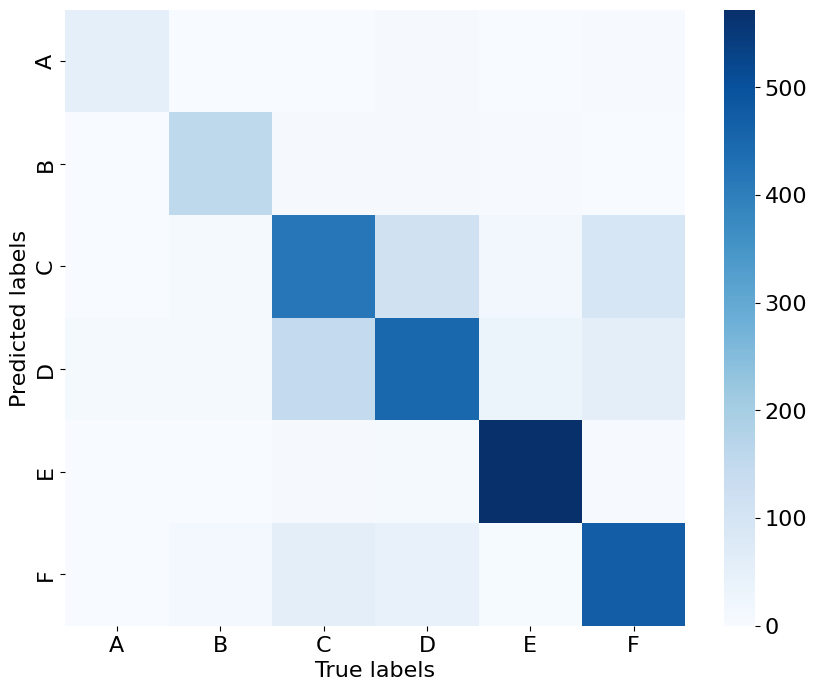

In [ ]:
y_bal_val = np.array(y_bal_val)
print(predictions[0])
print(np.argmax(y_bal_val, axis=-1).shape)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Categorization Model: CAT_V2

In [ ]:
print(cat_Bal[:10])
cat_Bal, _ = pd.factorize(cat_Bal)
cat_Bal = tfk.utils.to_categorical(cat_Bal)
print(cat_Bal.shape)

['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
(27937, 6)


In [ ]:
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(
    X_Bal,
    cat_Bal,
    test_size = 0.1,
    random_state=seed,
    stratify=cat_Bal,)

In [ ]:
def build_model(input_shape, output1_shape, output2_shape):
  input = tfkl.Input(shape=input_shape)

  #category predictor
  C = tfkl.Conv1D(256,7,padding='same',activation='relu')(input)
  C = tfkl.Conv1D(256,7,padding='same',activation='relu')(C)
  C = tfkl.MaxPooling1D()(C)

  C = tfkl.Conv1D(128,5,padding='same',activation='relu')(C)
  C = tfkl.Conv1D(128,5,padding='same',activation='relu')(C)
  C = tfkl.MaxPooling1D()(C)

  C = tfkl.Conv1D(64,3,padding='same',activation='relu')(C)
  C = tfkl.Conv1D(64,3,padding='same',activation='relu')(C)
  C = tfkl.MaxPooling1D()(C)

  C = tfkl.Conv1D(32,3,padding='same',activation='relu')(C)
  C = tfkl.Conv1D(32,3,padding='same',activation='relu')(C)
  C = tfkl.GlobalAveragePooling1D()(C)
  C = tfkl.Dropout(0.5)(C)

  C = tfkl.Dense(100, activation='relu')(C)
  C = tfkl.Dropout(0.3)(C)
  C = tfkl.Dense(80, activation='relu')(C)
  C = tfkl.Dropout(0.3)(C)
  output = tfkl.Dense(output2_shape, activation='softmax')(C)

  model = tf.keras.Model(inputs=input, outputs=output, name='CAT_V2')
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

Model: "CAT_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 200, 256)          2048      
                                                                 
 conv1d_18 (Conv1D)          (None, 200, 256)          459008    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 100, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 100, 128)          163968    
                                                                 
 conv1d_20 (Conv1D)          (None, 100, 128)          82048     
                                                            

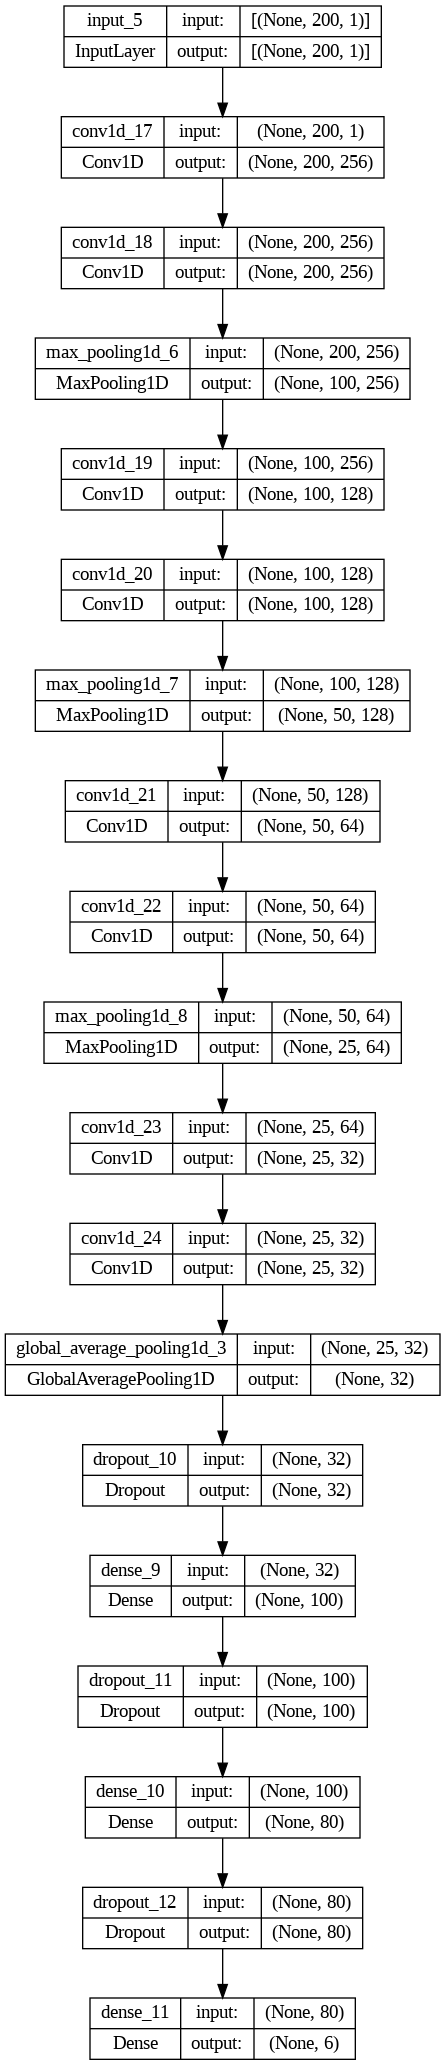

In [ ]:
model = build_model(input_shape, output1_shape, output2_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    X_bal_train,
    y_bal_train,
    batch_size = 16,
    epochs = 100,
    validation_data=(X_bal_val, y_bal_val),
    shuffle=True,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.3, min_lr=1e-5)
    ]
).history

Epoch 1/100
1572/1572 [==============================] - 20s 10ms/step - loss: 1.2969 - accuracy: 0.4363 - val_loss: 1.1389 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 2/100
1572/1572 [==============================] - 15s 9ms/step - loss: 1.0933 - accuracy: 0.5367 - val_loss: 1.0105 - val_accuracy: 0.5730 - lr: 0.0010
Epoch 3/100
1572/1572 [==============================] - 15s 9ms/step - loss: 0.9993 - accuracy: 0.5941 - val_loss: 0.9816 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 4/100
1572/1572 [==============================] - 15s 10ms/step - loss: 0.9492 - accuracy: 0.6128 - val_loss: 0.9029 - val_accuracy: 0.6246 - lr: 0.0010
Epoch 5/100
1572/1572 [==============================] - 15s 9ms/step - loss: 0.9089 - accuracy: 0.6361 - val_loss: 0.8598 - val_accuracy: 0.6614 - lr: 0.0010
Epoch 6/100
1572/1572 [==============================] - 15s 9ms/step - loss: 0.8848 - accuracy: 0.6470 - val_loss: 0.8552 - val_accuracy: 0.6664 - lr: 0.0010
Epoch 7/100
1572/1572 [=====================

In [ ]:
model.save('Models//'+model.name)

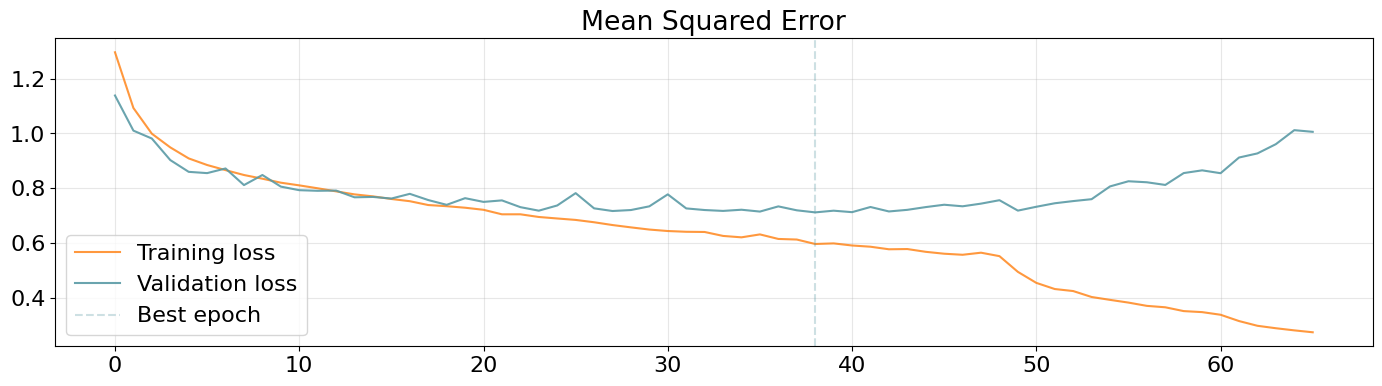

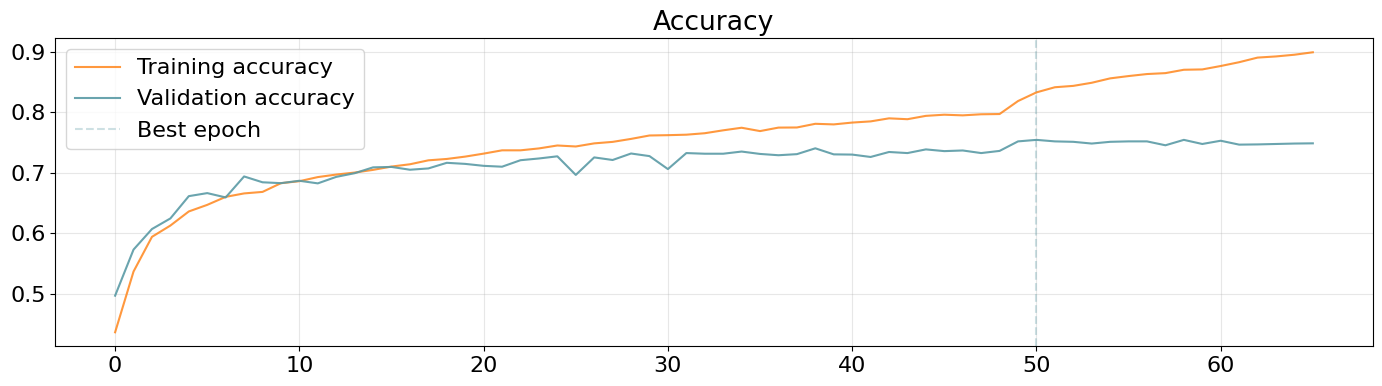

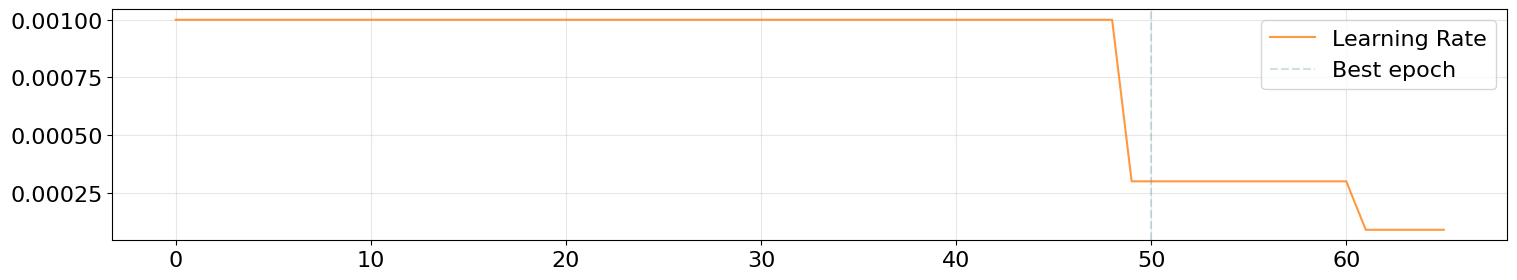

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
label_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_bal_val, verbose=0)
predictions.shape

(2794, 6)

(2794, 6)
Accuracy: 0.7545
Precision: 0.7862
Recall: 0.7496
F1: 0.7636


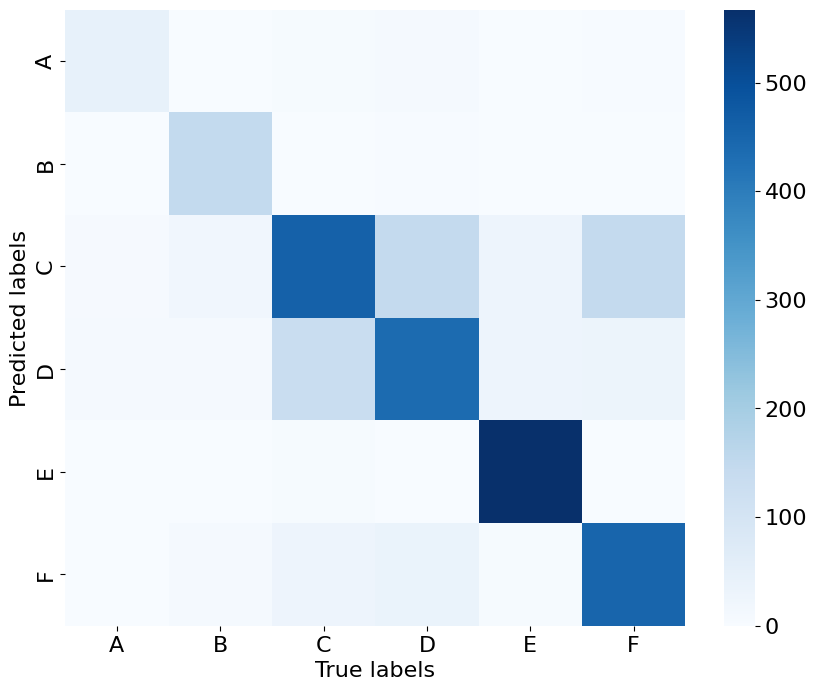

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Categorization Model: CAT_V3

In [ ]:
print(cat_Bal[:10])
cat_Bal, _ = pd.factorize(cat_Bal)
cat_Bal = tfk.utils.to_categorical(cat_Bal)
print(cat_Bal.shape)

['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
(10121, 6)


In [ ]:
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(
    X_Bal,
    cat_Bal,
    test_size = 0.1,
    random_state=seed,
    stratify=cat_Bal,)

In [ ]:
# we tried an hybrid approach, using the convolutional part and overall
# architecture as we had studied for the image classification case, adding the
# Recurrent GRU layers to have the sequence processing ability.
# we put the recurrent part at the end of feature extraction to reduce
# drastically the size and computing load of the model

def build_model(input_shape, output1_shape, output2_shape):
  input = tfkl.Input(shape=input_shape)

  #category predictor
  C = tfkl.Conv1D(128,5,padding='same',activation='relu')(input)
  C = tfkl.Conv1D(128,5,padding='same',activation='relu')(C)
  C = tfkl.MaxPooling1D()(C)

  C = tfkl.Conv1D(64,3,padding='same',activation='relu')(C)
  C = tfkl.Conv1D(64,3,padding='same',activation='relu')(C)
  C = tfkl.MaxPooling1D()(C)

  C = tfkl.Conv1D(32,3,padding='same',activation='relu')(C)
  C = tfkl.Conv1D(32,3,padding='same',activation='relu')(C)

  C = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True))(C)
  C = tfkl.Bidirectional(tfkl.GRU(256))(C)
  C = tfkl.Dropout(0.5)(C)

  C = tfkl.Dense(100, activation='relu')(C)
  C = tfkl.Dropout(0.3)(C)
  C = tfkl.Dense(80, activation='relu')(C)
  C = tfkl.Dropout(0.3)(C)
  output = tfkl.Dense(output2_shape, activation='softmax')(C)

  model = tf.keras.Model(inputs=input, outputs=output, name='CAT_V3')
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

Model: "CAT_V3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 200, 128)          768       
                                                                 
 conv1d_9 (Conv1D)           (None, 200, 128)          82048     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 100, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 100, 64)           24640     
                                                                 
 conv1d_11 (Conv1D)          (None, 100, 64)           12352     
                                                            

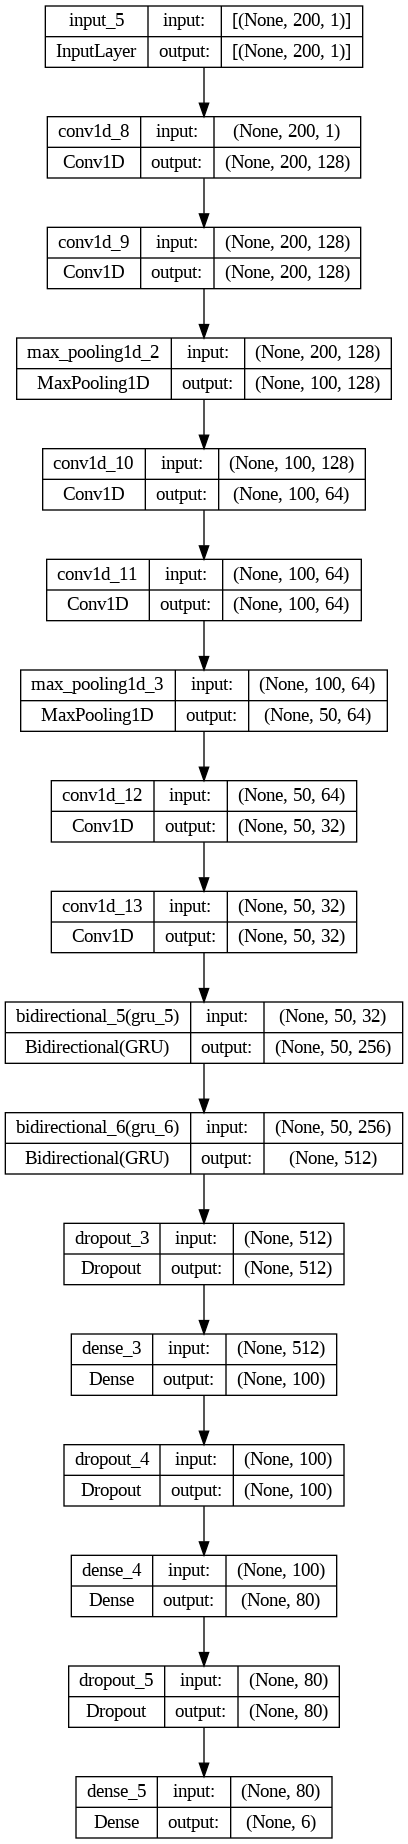

In [ ]:
model = build_model(input_shape, output1_shape, output2_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    X_bal_train,
    y_bal_train,
    batch_size = 16,
    epochs = 100,
    validation_data=(X_bal_val, y_bal_val),
    shuffle=True,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.3, min_lr=1e-5)
    ]
).history

Epoch 1/100
570/570 [==============================] - 20s 20ms/step - loss: 1.4447 - accuracy: 0.4212 - val_loss: 1.2218 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 2/100
570/570 [==============================] - 11s 19ms/step - loss: 1.2292 - accuracy: 0.5351 - val_loss: 1.1739 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 3/100
570/570 [==============================] - 9s 17ms/step - loss: 1.1446 - accuracy: 0.5697 - val_loss: 1.0462 - val_accuracy: 0.6170 - lr: 0.0010
Epoch 4/100
570/570 [==============================] - 10s 18ms/step - loss: 1.0988 - accuracy: 0.5811 - val_loss: 1.0918 - val_accuracy: 0.5805 - lr: 0.0010
Epoch 5/100
570/570 [==============================] - 11s 19ms/step - loss: 1.0625 - accuracy: 0.5930 - val_loss: 1.0181 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 6/100
570/570 [==============================] - 10s 18ms/step - loss: 1.0339 - accuracy: 0.6023 - val_loss: 0.9479 - val_accuracy: 0.6229 - lr: 0.0010
Epoch 7/100
570/570 [==============================] 

In [ ]:
model.save('Models//'+model.name)

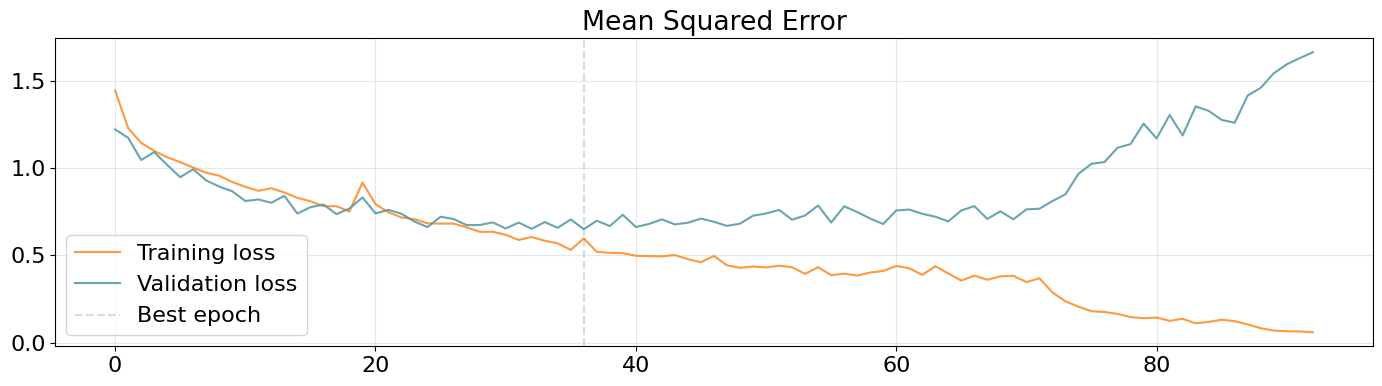

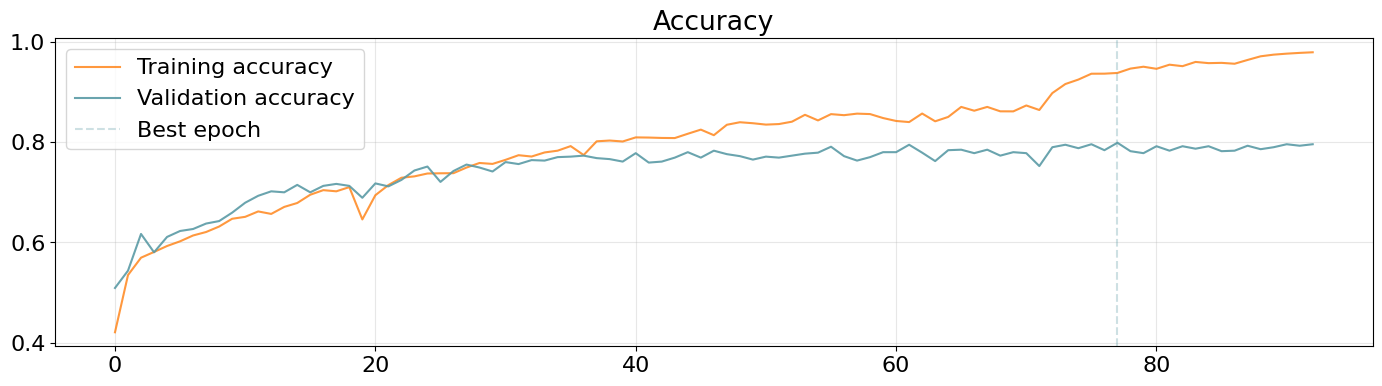

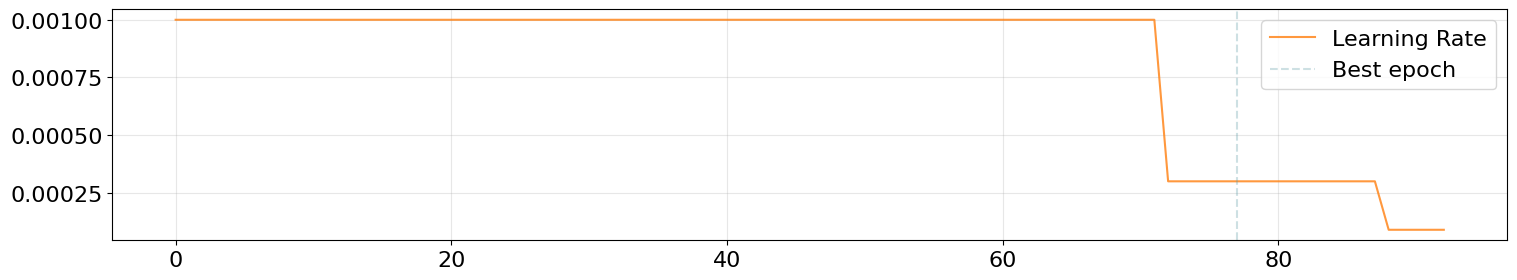

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
label_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_bal_val, verbose=0)
predictions.shape

(1013, 6)

Accuracy: 0.7986
Precision: 0.8152
Recall: 0.8211
F1: 0.8176


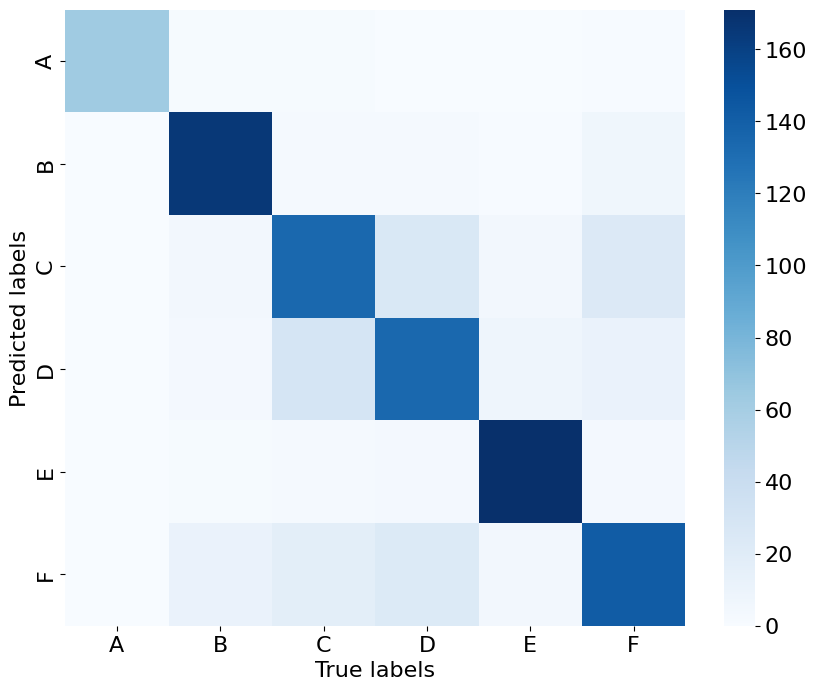

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Categorization Model: CAT_V4

In [ ]:
print(cat_Bal[:10])
cat_Bal, _ = pd.factorize(cat_Bal)
cat_Bal = tfk.utils.to_categorical(cat_Bal)
print(cat_Bal.shape)

['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
(10121, 6)


In [ ]:
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(
    X_Bal,
    cat_Bal,
    test_size = 0.1,
    random_state=seed,
    stratify=cat_Bal,)

In [ ]:

def build_model(input_shape, output1_shape, output2_shape):
  input = tfkl.Input(shape=input_shape)

  #category predictor
  C = tfkl.Conv1D(256,7,padding='valid',activation='relu')(input)
  C = tfkl.Conv1D(256,7,padding='valid',activation='relu')(C)
  C = tfkl.MaxPooling1D()(C)

  C = tfkl.Conv1D(128,5,padding='valid',activation='relu')(C)
  C = tfkl.Conv1D(128,5,padding='valid',activation='relu')(C)
  C = tfkl.MaxPooling1D()(C)

  C = tfkl.Conv1D(64,3,padding='valid',activation='relu')(C)
  C = tfkl.Conv1D(64,3,padding='valid',activation='relu')(C)
  C = tfkl.Dropout(0.3)(C)

  C = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True))(C)
  C = tfkl.Bidirectional(tfkl.GRU(64))(C)
  C = tfkl.Dropout(0.5)(C)

  C = tfkl.Dense(100, activation='relu')(C)
  C = tfkl.Dropout(0.4)(C)
  C = tfkl.Dense(80, activation='relu')(C)
  C = tfkl.Dropout(0.4)(C)
  output = tfkl.Dense(output2_shape, activation='softmax')(C)

  model = tf.keras.Model(inputs=input, outputs=output, name='CAT_V4')
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

Model: "CAT_V4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_28 (Conv1D)          (None, 194, 256)          2048      
                                                                 
 conv1d_29 (Conv1D)          (None, 188, 256)          459008    
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 94, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_30 (Conv1D)          (None, 90, 128)           163968    
                                                                 
 conv1d_31 (Conv1D)          (None, 86, 128)           82048     
                                                            

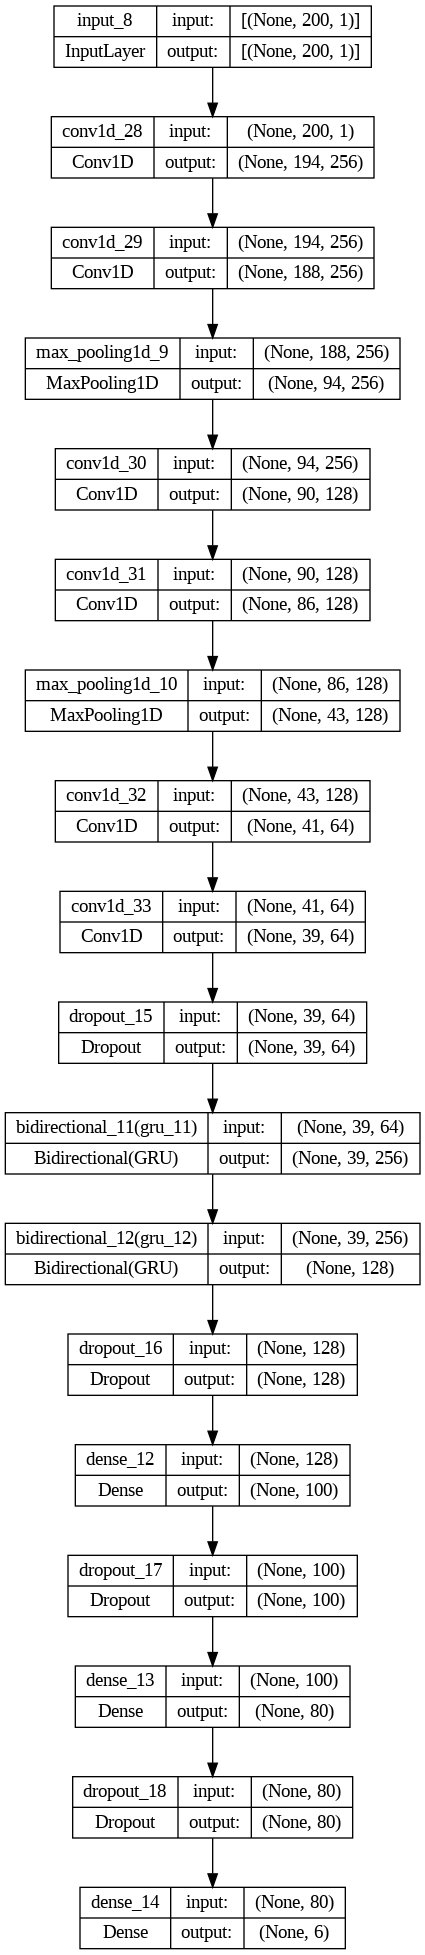

In [ ]:
model = build_model(input_shape, output1_shape, output2_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    X_bal_train,
    y_bal_train,
    batch_size = 16,
    epochs = 100,
    validation_data=(X_bal_val, y_bal_val),
    shuffle=True,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.3, min_lr=1e-5)
    ]
).history

Epoch 1/100
570/570 [==============================] - 22s 19ms/step - loss: 1.5776 - accuracy: 0.3567 - val_loss: 1.3884 - val_accuracy: 0.4551 - lr: 0.0010
Epoch 2/100
570/570 [==============================] - 10s 18ms/step - loss: 1.3668 - accuracy: 0.4786 - val_loss: 1.1557 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 3/100
570/570 [==============================] - 10s 17ms/step - loss: 1.2662 - accuracy: 0.5098 - val_loss: 1.0703 - val_accuracy: 0.5805 - lr: 0.0010
Epoch 4/100
570/570 [==============================] - 9s 16ms/step - loss: 1.2095 - accuracy: 0.5392 - val_loss: 1.0634 - val_accuracy: 0.5903 - lr: 0.0010
Epoch 5/100
570/570 [==============================] - 10s 18ms/step - loss: 1.1696 - accuracy: 0.5451 - val_loss: 1.0646 - val_accuracy: 0.5745 - lr: 0.0010
Epoch 6/100
570/570 [==============================] - 9s 17ms/step - loss: 1.1113 - accuracy: 0.5662 - val_loss: 1.0324 - val_accuracy: 0.5903 - lr: 0.0010
Epoch 7/100
570/570 [==============================] -

In [ ]:
model.save('Models//'+model.name)

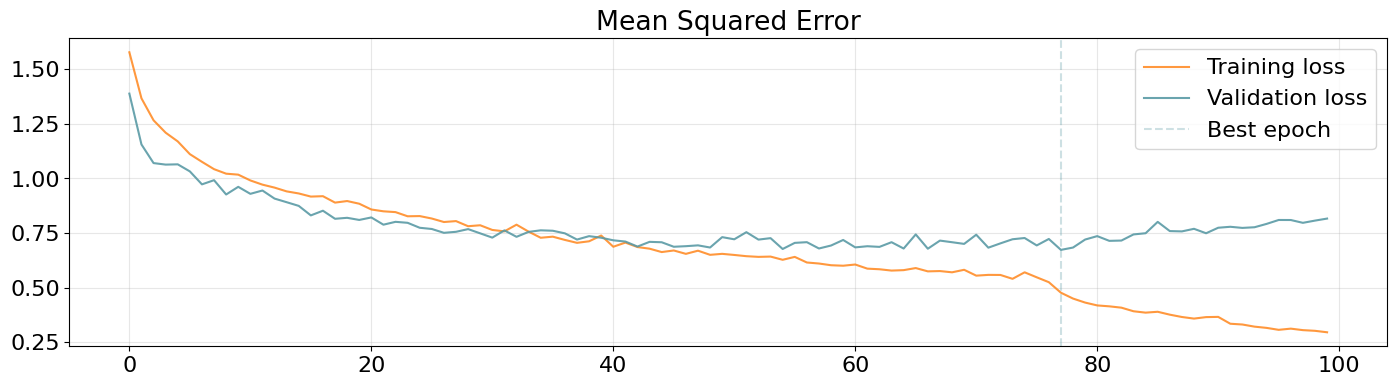

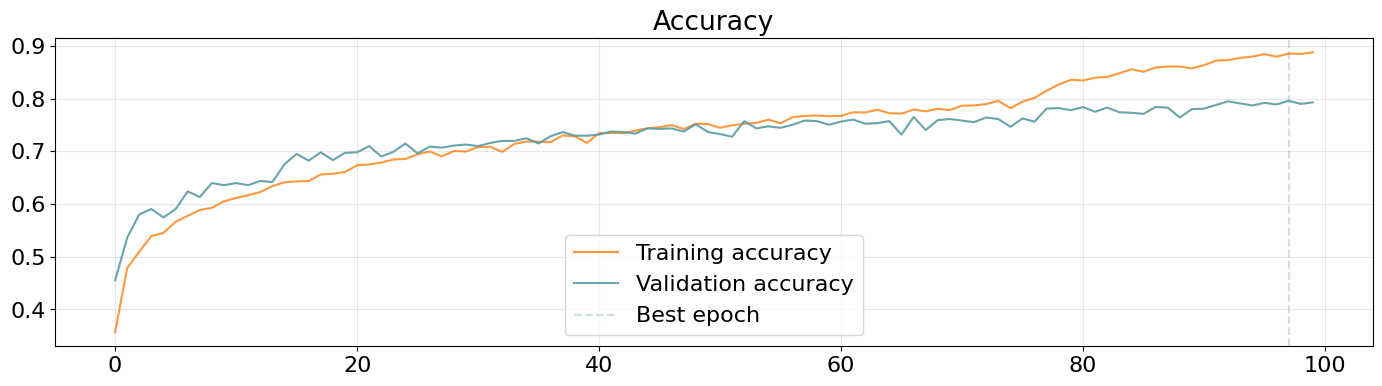

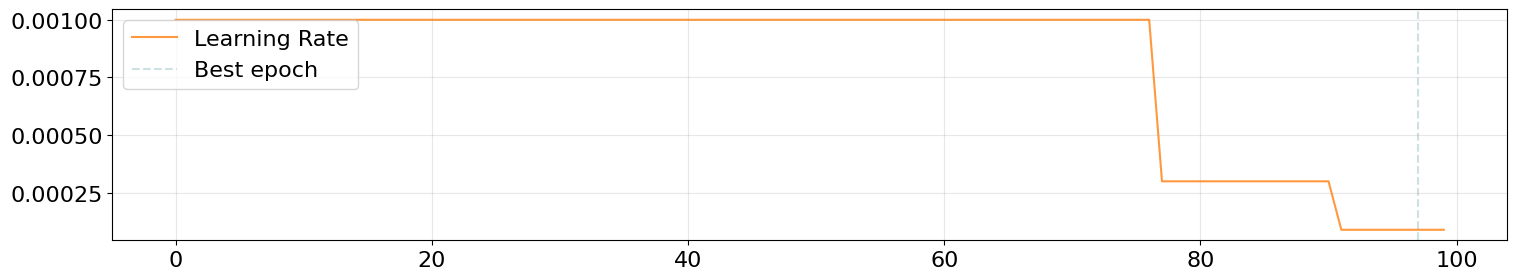

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
label_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_bal_val, verbose=0)
predictions.shape

(1013, 6)

Accuracy: 0.7927
Precision: 0.8141
Recall: 0.8158
F1: 0.8132


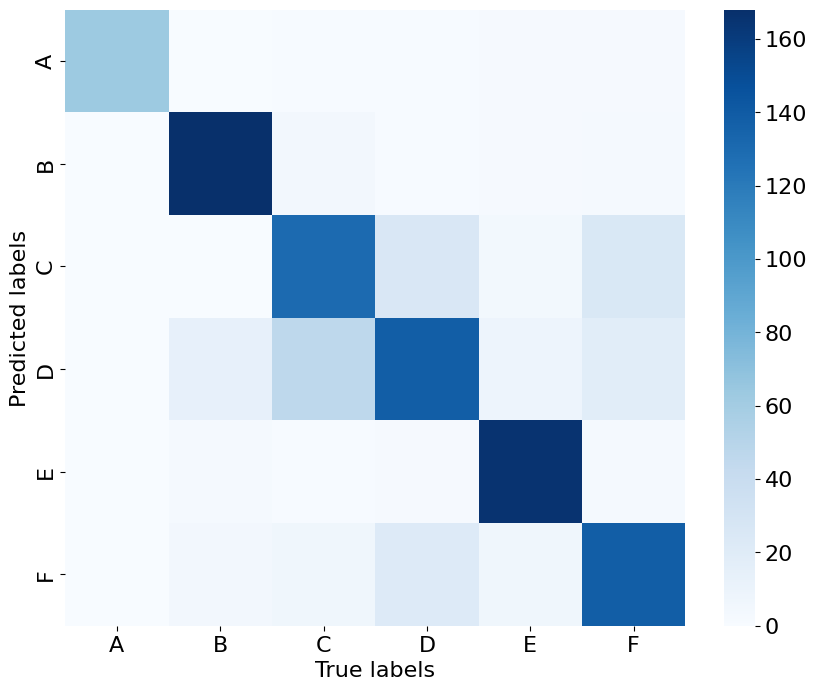

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Categorization Model: CAT_V5_Multiscale

In [ ]:
print(cat_Bal[:10])
cat_Bal, _ = pd.factorize(cat_Bal)
cat_Bal = tfk.utils.to_categorical(cat_Bal)
print(cat_Bal.shape)

['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']
(162264, 6)


In [ ]:
X_bal_train, X_bal_val, y_bal_train, y_bal_val = train_test_split(
    X_Bal,
    cat_Bal,
    test_size = 0.1,
    random_state=seed,
    stratify=cat_Bal,)

In [ ]:
def ResidualBlock(input, F, K):
  SK = tfkl.Conv1D(1, K, padding='same', activation='relu')(input)

  B = tfkl.Conv1D(F, K, padding='same', activation='relu')(input)
  B = tfkl.Conv1D(F, K, padding='same', activation='relu')(B)
  B = tfkl.BatchNormalization()(B)

  B = tfkl.Concatenate(axis=-1)([B,SK])
  return tfkl.Dropout(0.3)(B)

def build_model(input_shape, output1_shape, output2_shape):
  input = tfkl.Input(shape=input_shape)

  C = ResidualBlock(input, 256, 7)
  C = tfkl.MaxPooling1D()(C)
  C = ResidualBlock(C, 128, 3)
  C = tfkl.MaxPooling1D()(C)
  C = ResidualBlock(C, 64, 3)
  C = tfkl.MaxPooling1D()(C)
  C = ResidualBlock(C, 32, 3)

  C = tfkl.GlobalAveragePooling1D()(C)
  C = tfkl.Dropout(0.5)(C)

  C = tfkl.Dense(100, activation='relu')(C)
  C = tfkl.Dropout(0.4)(C)
  C = tfkl.Dense(80, activation='relu')(C)
  C = tfkl.Dropout(0.4)(C)
  output = tfkl.Dense(output2_shape, activation='softmax')(C)

  model = tf.keras.Model(inputs=input, outputs=output, name='CAT_V5_Multiscale')
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

Model: "CAT_V5_Multiscale"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_16 (Conv1D)          (None, 200, 256)             2048      ['input_5[0][0]']             
                                                                                                  
 conv1d_17 (Conv1D)          (None, 200, 256)             459008    ['conv1d_16[0][0]']           
                                                                                                  
 batch_normalization_5 (Bat  (None, 200, 256)             1024      ['conv1d_17[0][0]']           
 chNormalization)                                                                 

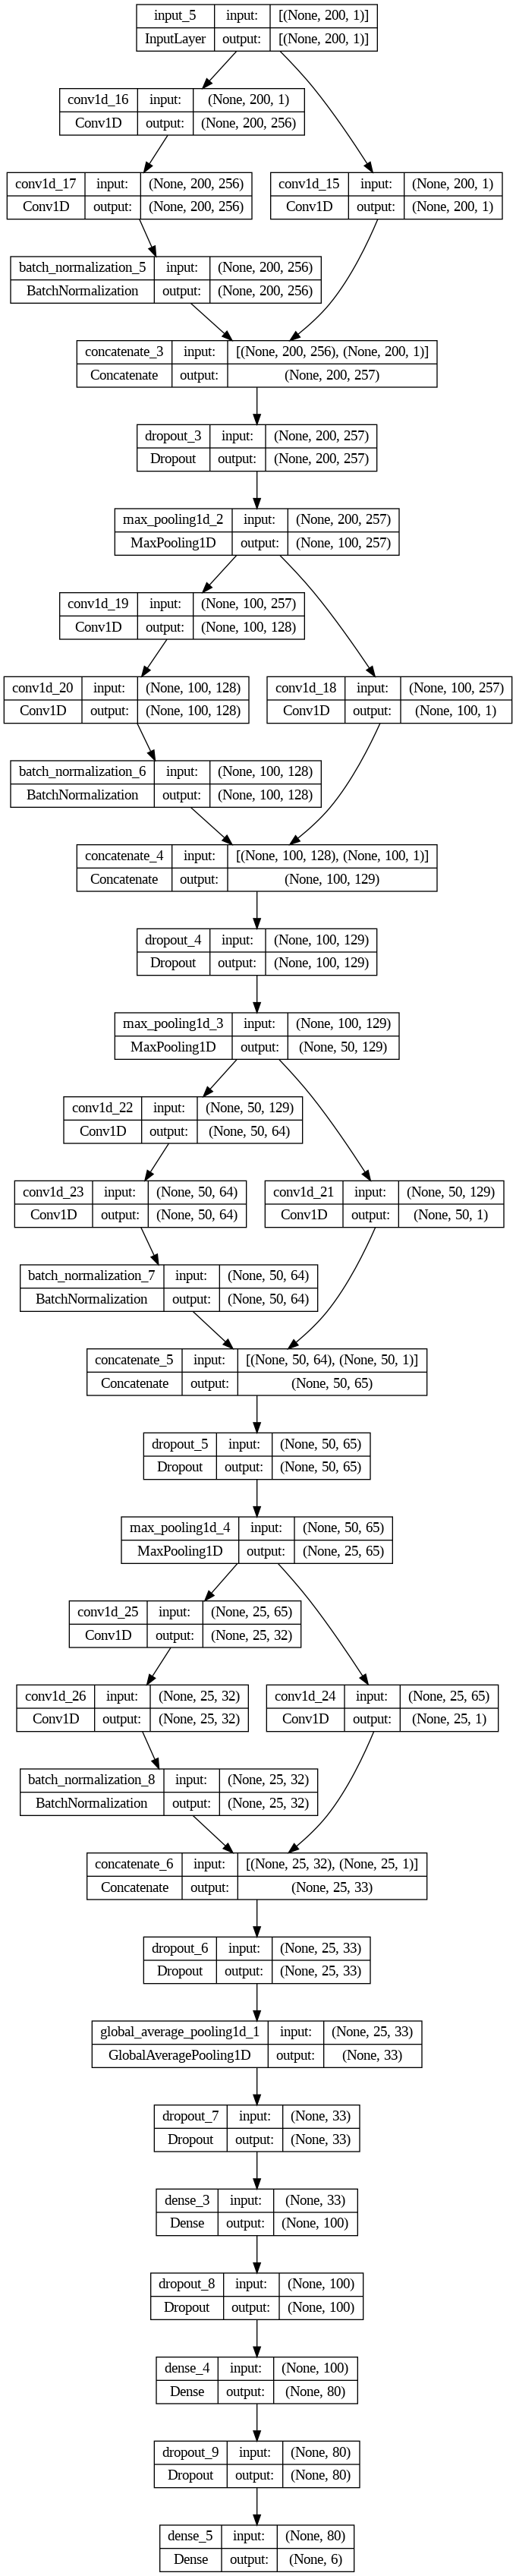

In [ ]:
model = build_model(input_shape, output1_shape, output2_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    X_bal_train,
    y_bal_train,
    batch_size = 64,
    epochs = 150,
    validation_data=(X_bal_val, y_bal_val),
    shuffle=True,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.3, min_lr=1e-5)
    ]
).history

Epoch 1/150
2282/2282 [==============================] - 64s 24ms/step - loss: 1.5966 - accuracy: 0.2775 - val_loss: 1.7206 - val_accuracy: 0.3109 - lr: 0.0010
Epoch 2/150
2282/2282 [==============================] - 52s 23ms/step - loss: 1.4046 - accuracy: 0.4186 - val_loss: 1.5398 - val_accuracy: 0.3662 - lr: 0.0010
Epoch 3/150
2282/2282 [==============================] - 52s 23ms/step - loss: 1.3051 - accuracy: 0.4775 - val_loss: 1.3855 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 4/150
2282/2282 [==============================] - 52s 23ms/step - loss: 1.2462 - accuracy: 0.5081 - val_loss: 1.2584 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 5/150
2282/2282 [==============================] - 51s 22ms/step - loss: 1.2036 - accuracy: 0.5320 - val_loss: 1.2910 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 6/150
2282/2282 [==============================] - 51s 23ms/step - loss: 1.1694 - accuracy: 0.5457 - val_loss: 1.0593 - val_accuracy: 0.5894 - lr: 0.0010
Epoch 7/150
2282/2282 [=================

In [ ]:
model.save('Models//'+model.name)

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
label_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5
}

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_bal_val, verbose=0)
predictions.shape

(16227, 6)

Accuracy: 0.8339
Precision: 0.822
Recall: 0.8222
F1: 0.8218


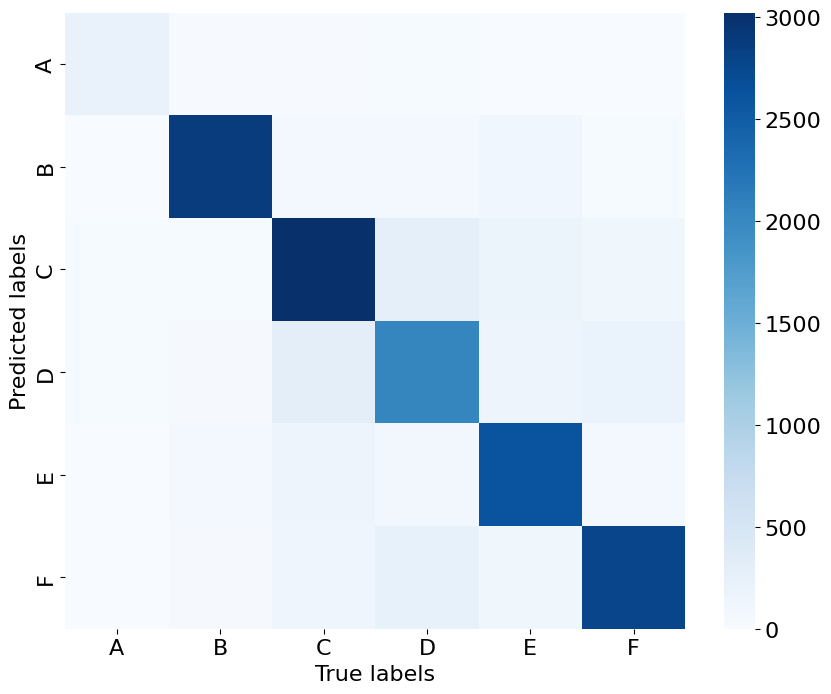

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_bal_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# GRU_CAT_V1

In [ ]:
def ResidualBlock(input, F, K):
  SK = tfkl.Conv1D(1, K, padding='same', activation='relu')(input)

  B = tfkl.Conv1D(F, K, padding='same', activation='relu')(input)
  B = tfkl.Conv1D(F, K, padding='same', activation='relu')(B)
  B = tfkl.BatchNormalization()(B)

  B = tfkl.Concatenate(axis=-1)([B,SK])
  return tfkl.Dropout(0.3)(B)

def build_model(input_shape, output1_shape, output2_shape):
  input = tfkl.Input(shape=input_shape)
  input2 = tfkl.Input(shape=(6))
  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(input)
  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(C)

  C = tfkl.Conv1D(32, 15, padding='same', activation='relu')(C)
  C = tfkl.Flatten()(C)
  C = tfkl.Dropout(0.4)(C)
  C = tfkl.Dense(50, activation='relu')(C)
  C = tfkl.Dense(30, activation='relu')(C)
  C = tfkl.Concatenate()([C, input2])
  output = tfkl.Dense(output1_shape[0], activation='relu', name='forecast')(C)

  model = tf.keras.Model(inputs=[input, input2], outputs=output, name='GRU_CAT_V2')
  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())

  return model

Model: "GRU_CAT_V2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_6 (Bidirecti  (None, 200, 64)              6720      ['input_7[0][0]']             
 onal)                                                                                            
                                                                                                  
 bidirectional_7 (Bidirecti  (None, 200, 64)              18816     ['bidirectional_6[0][0]']     
 onal)                                                                                            
                                                                                         

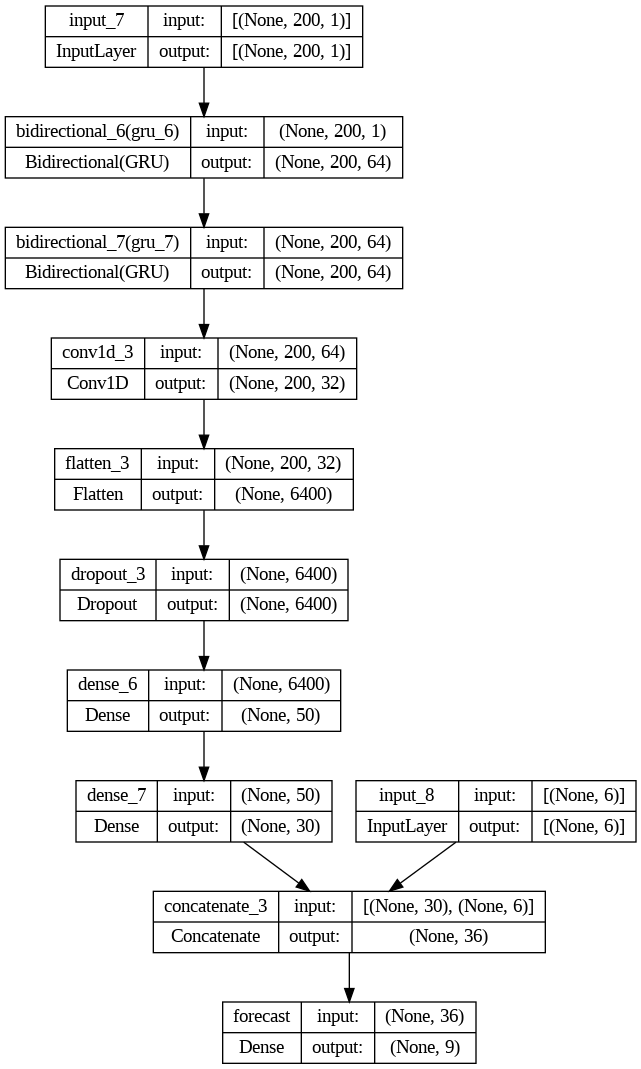

In [ ]:
model = build_model(input_shape, output1_shape, output2_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    [X_train, cat_train],
    y_train,
    batch_size = 64,
    epochs = 100,
    validation_data=([X_val, cat_val], y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/100
4048/4048 [==============================] - 119s 28ms/step - loss: 0.0109 - val_loss: 0.0072 - lr: 0.0010
Epoch 2/100
4048/4048 [==============================] - 111s 27ms/step - loss: 0.0078 - val_loss: 0.0071 - lr: 0.0010
Epoch 3/100
4048/4048 [==============================] - 108s 27ms/step - loss: 0.0074 - val_loss: 0.0067 - lr: 0.0010
Epoch 4/100
4048/4048 [==============================] - 108s 27ms/step - loss: 0.0072 - val_loss: 0.0069 - lr: 0.0010
Epoch 5/100
4048/4048 [==============================] - 109s 27ms/step - loss: 0.0070 - val_loss: 0.0066 - lr: 0.0010
Epoch 6/100
4048/4048 [==============================] - 108s 27ms/step - loss: 0.0069 - val_loss: 0.0073 - lr: 0.0010
Epoch 7/100
4048/4048 [==============================] - 109s 27ms/step - loss: 0.0067 - val_loss: 0.0064 - lr: 0.0010
Epoch 8/100
4048/4048 [==============================] - 111s 27ms/step - loss: 0.0066 - val_loss: 0.0063 - lr: 0.0010
Epoch 9/100
4048/4048 [=========================

KeyboardInterrupt: ignored

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# GRU_V1

In [ ]:
def build_model(input_shape):
  input = tfkl.Input(shape=input_shape)

  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(input)
  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(C)

  C = tfkl.Conv1D(32, 7, padding='same', activation='relu')(C)
  C = tfkl.Conv1D(32, 7, padding='same', activation='relu')(C)
  C = tfkl.Conv1D(32, 7, padding='same', activation='relu')(C)

  C = tfkl.Flatten()(C)
  output = tfkl.Dense(9, activation='sigmoid')(C)


  model = tf.keras.Model(inputs=input, outputs=output, name='GRU_V1')
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam())

  return model

Model: "GRU_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 200, 64)           6720      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 200, 64)           18816     
 onal)                                                           
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 32)           14368     
                                                                 
 conv1d_4 (Conv1D)           (None, 200, 32)           7200      
                                                                 
 conv1d_5 (Conv1D)           (None, 200, 32)           7200 

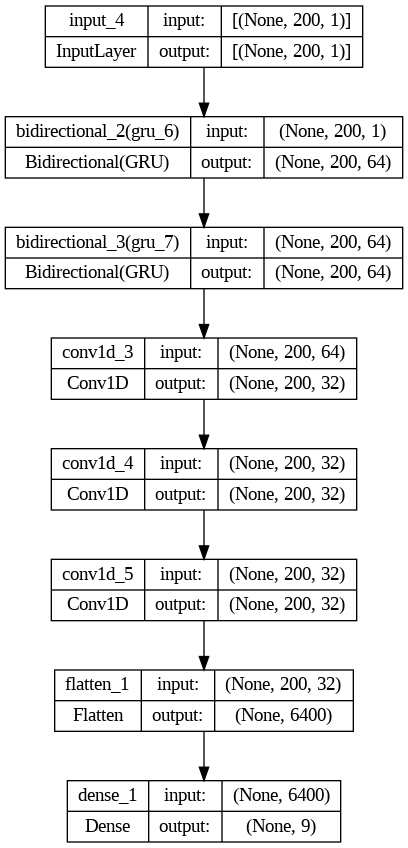

In [ ]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 150,
    validation_split=0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/150
7259/7259 [==============================] - 229s 30ms/step - loss: 0.0072 - val_loss: 0.0064 - lr: 0.0010
Epoch 2/150
7259/7259 [==============================] - 214s 29ms/step - loss: 0.0063 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/150
7259/7259 [==============================] - 214s 29ms/step - loss: 0.0061 - val_loss: 0.0061 - lr: 0.0010
Epoch 4/150
7259/7259 [==============================] - 217s 30ms/step - loss: 0.0060 - val_loss: 0.0061 - lr: 0.0010
Epoch 5/150
7259/7259 [==============================] - 215s 30ms/step - loss: 0.0059 - val_loss: 0.0060 - lr: 0.0010
Epoch 6/150
7259/7259 [==============================] - 217s 30ms/step - loss: 0.0058 - val_loss: 0.0060 - lr: 0.0010
Epoch 7/150
7259/7259 [==============================] - 213s 29ms/step - loss: 0.0058 - val_loss: 0.0060 - lr: 0.0010
Epoch 8/150
7259/7259 [==============================] - 217s 30ms/step - loss: 0.0057 - val_loss: 0.0060 - lr: 0.0010
Epoch 9/150
7259/7259 [=========================

In [ ]:
model.save('Models//'+model.name)

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# GRU_V1_W100

In [ ]:
def build_model(input_shape, output1_shape):
  input = tfkl.Input(shape=input_shape)

  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(input)
  C = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True))(C)

  C = tfkl.Conv1D(32, 15, padding='same', activation='relu')(C)

  C = tfkl.Flatten()(C)
  C = tfkl.Dropout(0.4)(C)
  C = tfkl.Dense(50, activation='relu')(C)
  C = tfkl.Dense(30, activation='relu')(C)
  output = tfkl.Dense(output1_shape[0], activation='sigmoid')(C)


  model = tf.keras.Model(inputs=input, outputs=output, name='GRU_V1_W100')
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam())

  return model

Model: "GRU_V1_W100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 100, 64)           6720      
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 100, 64)           18816     
 onal)                                                           
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 32)           30752     
                                                                 
 flatten_4 (Flatten)         (None, 3200)              0         
                                                                 
 dropout_4 (Dropout)         (None, 3200)              

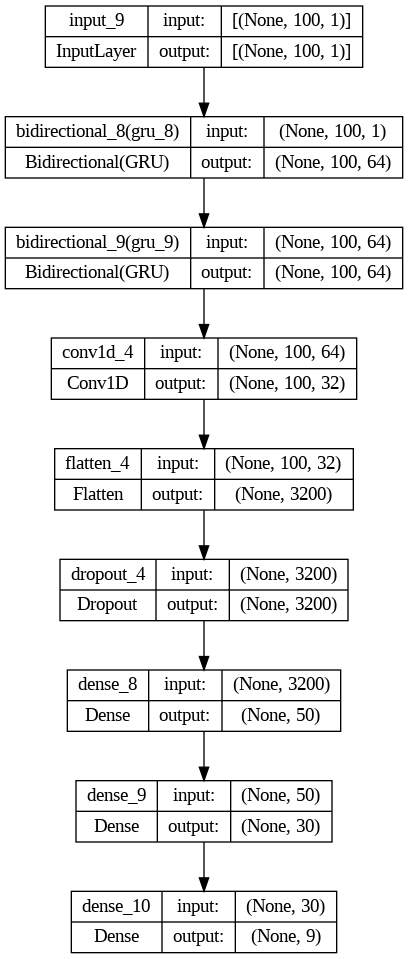

In [ ]:
model = build_model(input_shape, output1_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 150,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/150
4430/4430 [==============================] - 124s 19ms/step - loss: 0.0098 - val_loss: 0.0084 - lr: 0.0010
Epoch 2/150
4430/4430 [==============================] - 80s 18ms/step - loss: 0.0085 - val_loss: 0.0081 - lr: 0.0010
Epoch 3/150
4430/4430 [==============================] - 81s 18ms/step - loss: 0.0081 - val_loss: 0.0079 - lr: 0.0010
Epoch 4/150
4430/4430 [==============================] - 79s 18ms/step - loss: 0.0079 - val_loss: 0.0077 - lr: 0.0010
Epoch 5/150
4430/4430 [==============================] - 80s 18ms/step - loss: 0.0078 - val_loss: 0.0078 - lr: 0.0010
Epoch 6/150
4430/4430 [==============================] - 80s 18ms/step - loss: 0.0077 - val_loss: 0.0077 - lr: 0.0010
Epoch 7/150
4430/4430 [==============================] - 82s 19ms/step - loss: 0.0076 - val_loss: 0.0076 - lr: 0.0010
Epoch 8/150
4430/4430 [==============================] - 80s 18ms/step - loss: 0.0075 - val_loss: 0.0074 - lr: 0.0010
Epoch 9/150
2468/4430 [===============>..............] 

KeyboardInterrupt: ignored

In [ ]:
model.save('Models//'+model.name)

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Baseline

In [ ]:
def build_model(input_shape, output1_shape):
  input = tfkl.Input(shape=input_shape)

  C = tfkl.Flatten()(input)

  output = tfkl.Dense(output1_shape[0], activation='sigmoid')(C)


  model = tf.keras.Model(inputs=input, outputs=output, name='Baseline')
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam())

  return model

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 9)                 1809      
                                                                 
Total params: 1809 (7.07 KB)
Trainable params: 1809 (7.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


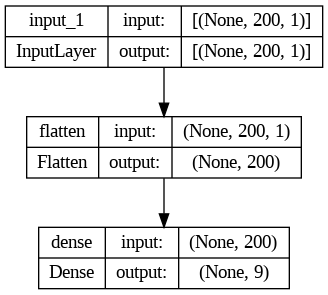

In [ ]:
model = build_model(input_shape, output1_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 150,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/150
4412/4412 [==============================] - 18s 3ms/step - loss: 0.0170 - val_loss: 0.0086 - lr: 0.0010
Epoch 2/150
4412/4412 [==============================] - 11s 3ms/step - loss: 0.0083 - val_loss: 0.0081 - lr: 0.0010
Epoch 3/150
4412/4412 [==============================] - 13s 3ms/step - loss: 0.0081 - val_loss: 0.0080 - lr: 0.0010
Epoch 4/150
4412/4412 [==============================] - 13s 3ms/step - loss: 0.0080 - val_loss: 0.0081 - lr: 0.0010
Epoch 5/150
4412/4412 [==============================] - 14s 3ms/step - loss: 0.0080 - val_loss: 0.0080 - lr: 0.0010
Epoch 6/150
4412/4412 [==============================] - 13s 3ms/step - loss: 0.0080 - val_loss: 0.0079 - lr: 0.0010
Epoch 7/150
4412/4412 [==============================] - 13s 3ms/step - loss: 0.0080 - val_loss: 0.0079 - lr: 0.0010
Epoch 8/150
4412/4412 [==============================] - 14s 3ms/step - loss: 0.0080 - val_loss: 0.0080 - lr: 0.0010
Epoch 9/150
4412/4412 [==============================] - 13s 3ms

In [ ]:
model.save('Models//'+model.name)

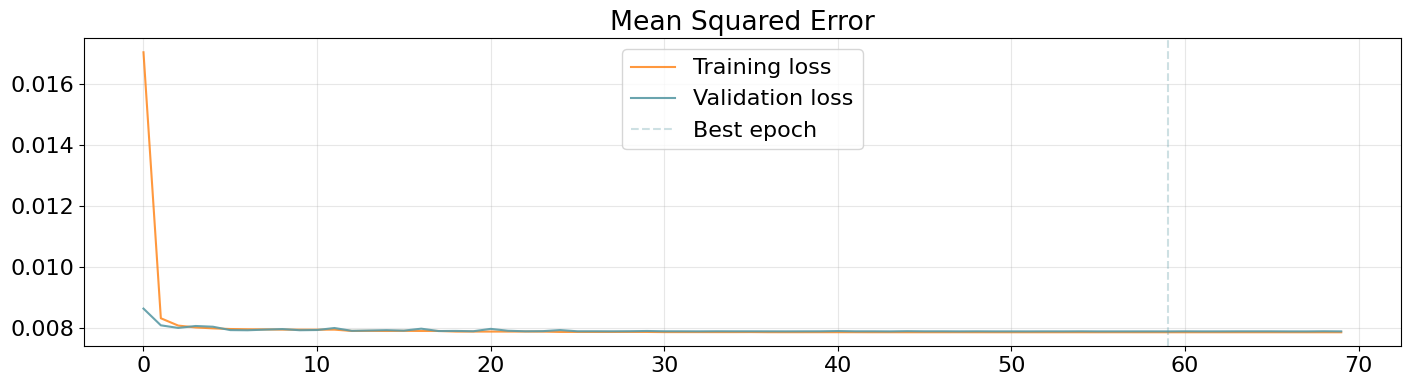

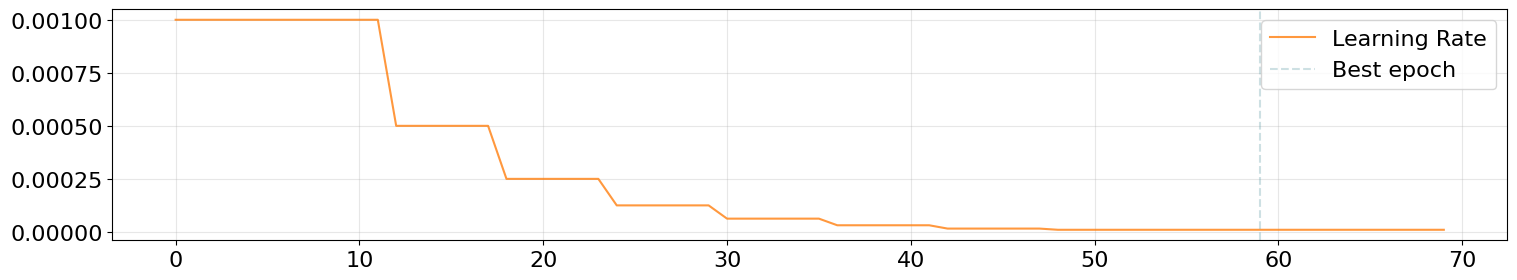

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# GRU_Baseline

In [ ]:

def build_model(input_shape, output1_shape):
  input = tfkl.Input(shape=input_shape)

  encoder = tfkl.GRU(128, return_sequences=True)(input)

  output = tfkl.GRU(output1_shape[0])(encoder)


  model = tf.keras.Model(inputs=input, outputs=output, name='GRU_Base')
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam())

  return model

Model: "GRU_Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 gru_2 (GRU)                 (None, 200, 128)          50304     
                                                                 
 gru_3 (GRU)                 (None, 9)                 3753      
                                                                 
Total params: 54057 (211.16 KB)
Trainable params: 54057 (211.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


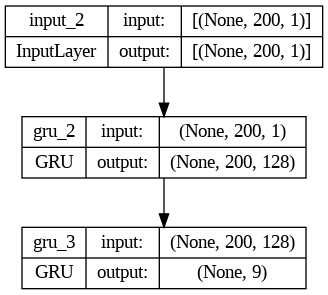

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 150,
    validation_split = 0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/150
7259/7259 [==============================] - 117s 15ms/step - loss: 0.0090 - val_loss: 0.0076 - lr: 0.0010
Epoch 2/150
7259/7259 [==============================] - 114s 16ms/step - loss: 0.0073 - val_loss: 0.0070 - lr: 0.0010
Epoch 3/150
7259/7259 [==============================] - 111s 15ms/step - loss: 0.0067 - val_loss: 0.0066 - lr: 0.0010
Epoch 4/150
7259/7259 [==============================] - 110s 15ms/step - loss: 0.0064 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/150
7259/7259 [==============================] - 111s 15ms/step - loss: 0.0062 - val_loss: 0.0062 - lr: 0.0010
Epoch 6/150
7259/7259 [==============================] - 113s 16ms/step - loss: 0.0061 - val_loss: 0.0061 - lr: 0.0010
Epoch 7/150
7259/7259 [==============================] - 115s 16ms/step - loss: 0.0060 - val_loss: 0.0060 - lr: 0.0010
Epoch 8/150
7259/7259 [==============================] - 110s 15ms/step - loss: 0.0059 - val_loss: 0.0059 - lr: 0.0010
Epoch 9/150
7259/7259 [=========================

In [ ]:
model.save('Models//'+model.name)

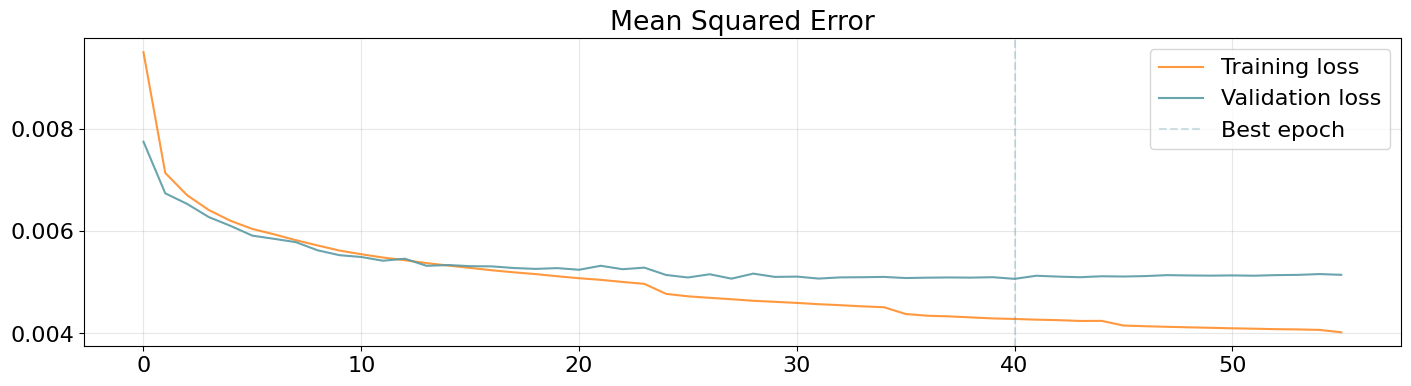

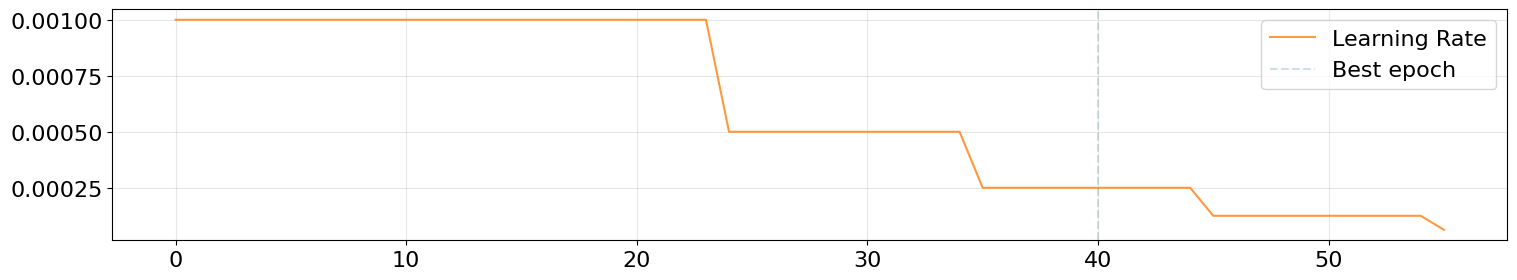

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# GRU_ATT_V1

In [ ]:
# create custom attention model following the slides
def build_model(input_shape, output1_shape):
  input = tfkl.Input(shape=input_shape)


  encoder = tfkl.GRU(64, return_sequences=True)(input)
  decoder = tfkl.GRU(64)(encoder)

  context = tfkl.Attention()([decoder, encoder])
  C = tfkl.Concatenate()([decoder, context[:,0,:]])

  output = tfkl.Dense(9, activation='sigmoid')(C)


  model = tf.keras.Model(inputs=input, outputs=output, name='GRU_ATT_V1')
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam())

  return model

Model: "GRU_ATT_V1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 gru_8 (GRU)                 (None, 200, 64)              12864     ['input_5[0][0]']             
                                                                                                  
 gru_9 (GRU)                 (None, 64)                   24960     ['gru_8[0][0]']               
                                                                                                  
 attention_1 (Attention)     (None, None, 64)             0         ['gru_9[0][0]',               
                                                                     'gru_8[0][0]']      

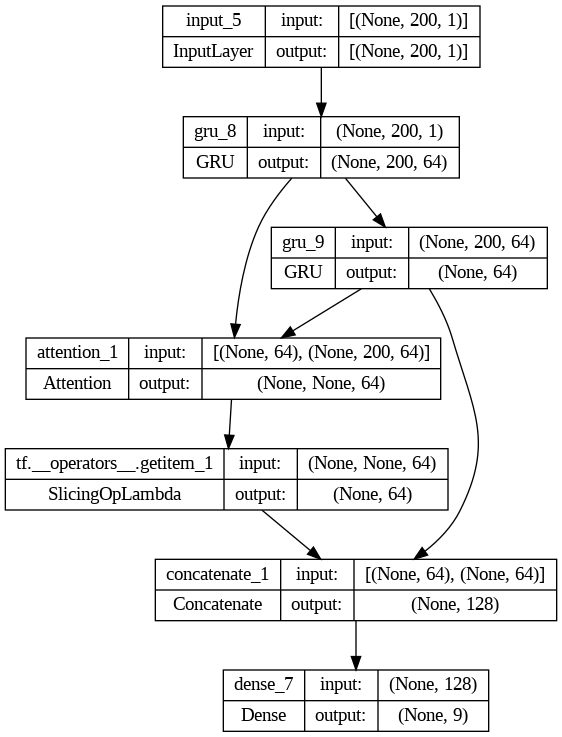

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 150,
    validation_split=0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.5, min_lr=1e-5)
    ]
).history

KeyboardInterrupt: ignored

In [ ]:
model.save('Models//'+model.name)

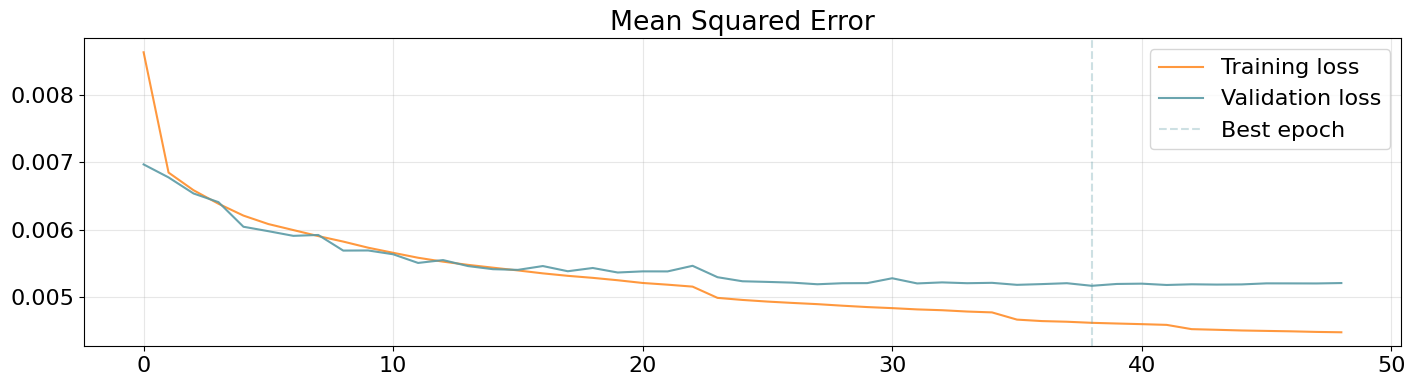

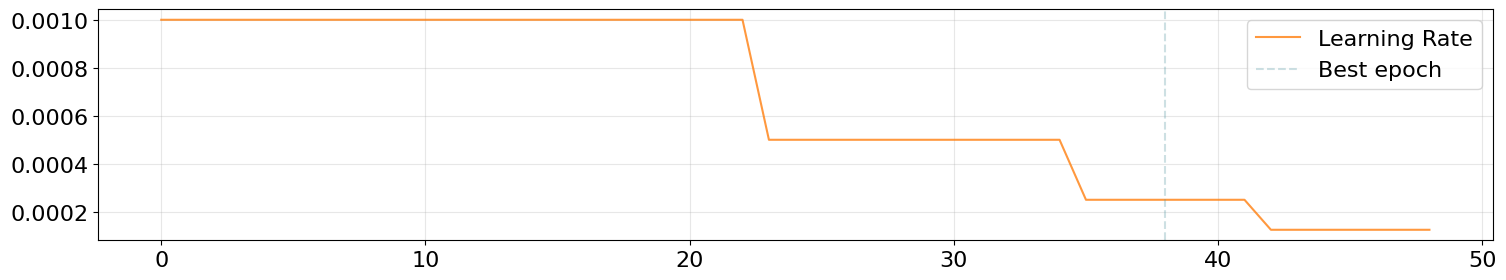

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# GRU_ATT_V2

In [ ]:
# create custom attention model following the slides
def build_model(input_shape, output1_shape):
  input = tfkl.Input(shape=input_shape)

  C = tfkl.Bidirectional(tfkl.GRU(16, return_sequences=True))(input)
  C = tfkl.Bidirectional(tfkl.GRU(16, return_sequences=True))(C)

  C = tfkl.Conv1D(16, 15, padding='same', activation='relu')(C)
  C = tfkl.Flatten()(C)
  output = tfkl.Dense(1, activation='relu')(C)


  model = tf.keras.Model(inputs=input, outputs=output, name='GRU_ATT_V2')
  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(), metrics=['mse'])

  return model

Model: "GRU_ATT_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 bidirectional (Bidirection  (None, 200, 32)           1824      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 32)           4800      
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, 200, 16)           7696      
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 1)                 3

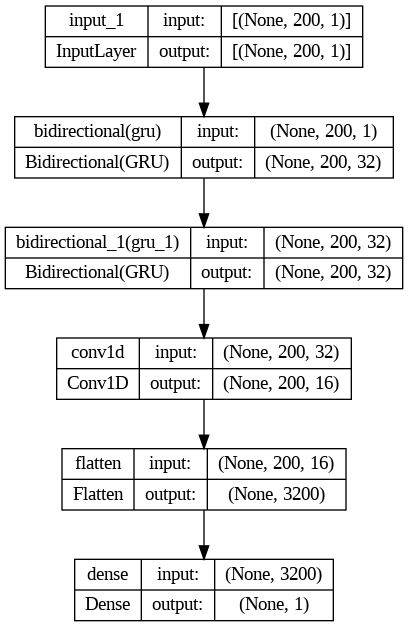

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs = 150,
    validation_split=0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/150
3630/3630 [==============================] - 115s 28ms/step - loss: 0.0396 - mse: 0.0051 - val_loss: 0.0390 - val_mse: 0.0035 - lr: 0.0010
Epoch 2/150
3630/3630 [==============================] - 100s 28ms/step - loss: 0.0322 - mse: 0.0032 - val_loss: 0.0303 - val_mse: 0.0029 - lr: 0.0010
Epoch 3/150
3630/3630 [==============================] - 100s 28ms/step - loss: 0.0315 - mse: 0.0031 - val_loss: 0.0315 - val_mse: 0.0030 - lr: 0.0010
Epoch 4/150
3630/3630 [==============================] - 100s 28ms/step - loss: 0.0313 - mse: 0.0031 - val_loss: 0.0300 - val_mse: 0.0029 - lr: 0.0010
Epoch 5/150
3630/3630 [==============================] - 98s 27ms/step - loss: 0.0310 - mse: 0.0030 - val_loss: 0.0302 - val_mse: 0.0029 - lr: 0.0010
Epoch 6/150
3630/3630 [==============================] - 99s 27ms/step - loss: 0.0308 - mse: 0.0030 - val_loss: 0.0296 - val_mse: 0.0029 - lr: 0.0010
Epoch 7/150
3630/3630 [==============================] - 98s 27ms/step - loss: 0.0307 - mse: 0.0

KeyboardInterrupt: ignored

In [ ]:
model.save('Models//'+model.name)

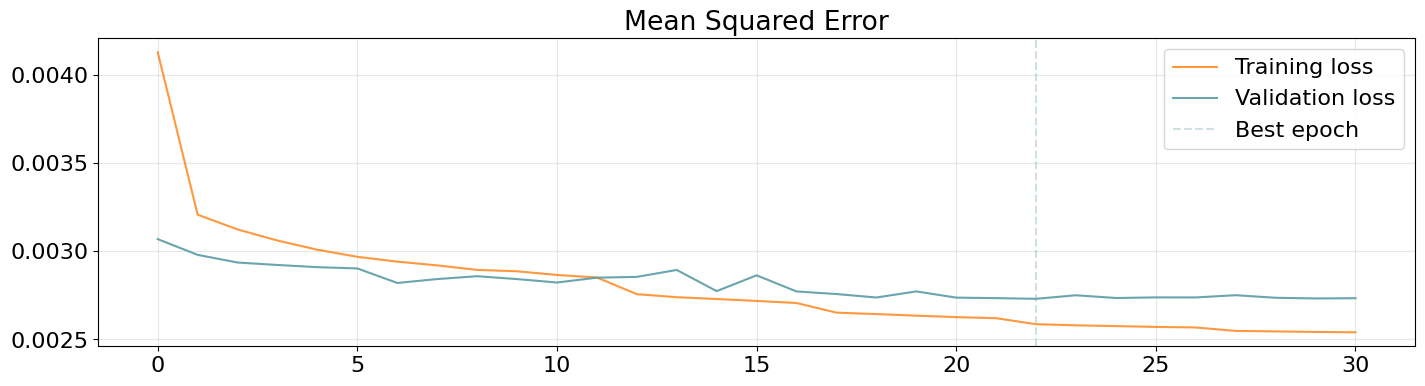

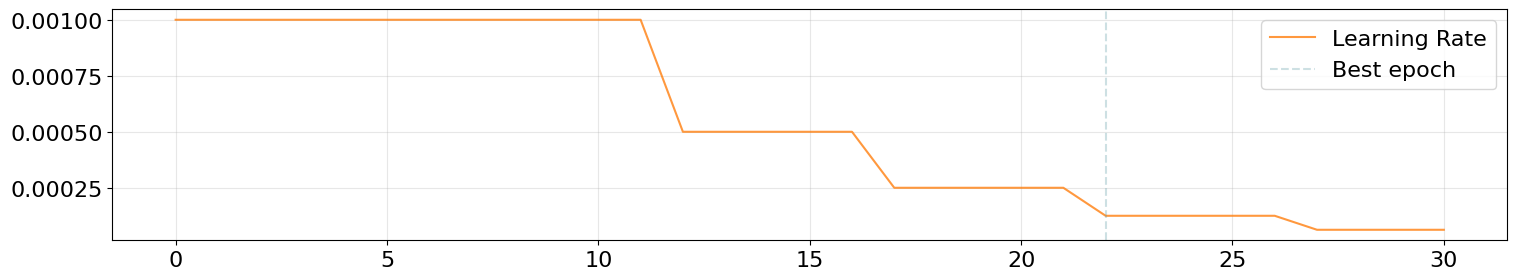

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Maximus Prime

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfkl.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(9)(x)
    return tfk.Model(inputs, outputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 200, 1)               2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 200, 1)               2101      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

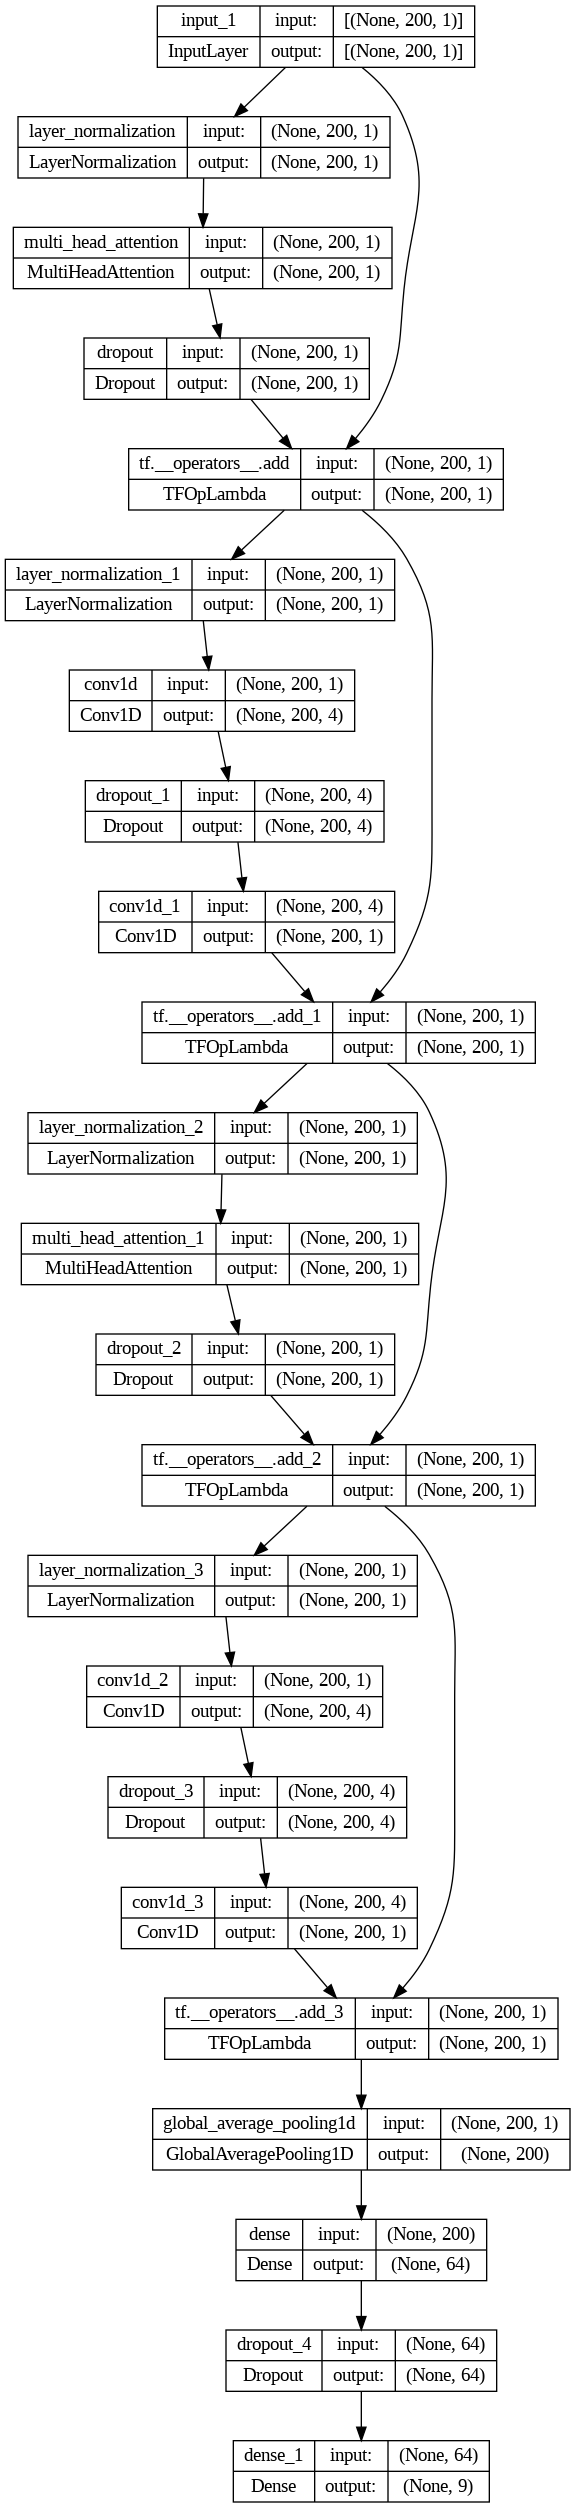

In [ ]:

model = build_model(
    (200, 1),
    head_size=100,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[64],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4)
)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 150,
    validation_split=0.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/150
7259/7259 [==============================] - 208s 29ms/step - loss: 0.0365 - val_loss: 0.0092 - lr: 1.0000e-04
Epoch 2/150
7259/7259 [==============================] - 212s 29ms/step - loss: 0.0131 - val_loss: 0.0081 - lr: 1.0000e-04
Epoch 3/150
7259/7259 [==============================] - 209s 29ms/step - loss: 0.0108 - val_loss: 0.0077 - lr: 1.0000e-04
Epoch 4/150
7259/7259 [==============================] - 208s 29ms/step - loss: 0.0100 - val_loss: 0.0075 - lr: 1.0000e-04
Epoch 5/150
7259/7259 [==============================] - 208s 29ms/step - loss: 0.0097 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 6/150
7259/7259 [==============================] - 206s 28ms/step - loss: 0.0096 - val_loss: 0.0073 - lr: 1.0000e-04
Epoch 7/150
7259/7259 [==============================] - 208s 29ms/step - loss: 0.0095 - val_loss: 0.0073 - lr: 1.0000e-04
Epoch 8/150
7259/7259 [==============================] - 208s 29ms/step - loss: 0.0094 - val_loss: 0.0073 - lr: 1.0000e-04
Epoch 9/150
7259

KeyboardInterrupt: ignored

In [ ]:
model.save('Models//'+model.name)

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Composite Prediction

In [ ]:
model = tfk.models.load_model('Models//Deiv_0047')

In [ ]:
def predict(input):
  input = tf.reshape(input, (-1, input.shape[0], 1))
  prediction = []
  prediction.append(model.predict(input))
  for i in range(1, 2):
    I = tf.cast(input[:, i*9:, :], tf.float32)
    predsofar = tf.cast(prediction, tf.float32)
    predsofar = tf.reshape(predsofar, (-1, 9, 1))
    I = tf.concat([I, predsofar], axis=1)
    prediction.append(model.predict(I))
  return tf.cast(tf.reshape(prediction, (18)), tf.float64)

In [ ]:
print(X_test.shape)
predictions = tf.map_fn(predict, X_test[:5000])

print(tf.reduce_mean(tf.square(y_test[:5000]-predictions), axis=(0, 1)))

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 33ms/step
tf.Tensor(0.008845448766645126, shape=(), dtype=float64)


# Composite Prediction

In [ ]:
models = [tfk.models.load_model('Models//Deiv_0047'), tfk.models.load_model('Models//GRU_Base')]

In [ ]:
def predict(input):
  input = tf.reshape(input, (-1, input.shape[0], 1))
  prediction = []

  p=[]
  for m in models: p.append(m.predict(input))
  prediction.append(tf.reduce_mean(p, axis=0))

  for i in range(1, 2):
    I = tf.cast(input[:, i*9:, :], tf.float32)
    predsofar = tf.cast(prediction, tf.float32)
    predsofar = tf.reshape(predsofar, (-1, 9, 1))
    I = tf.concat([I, predsofar], axis=1)

    p=[]
    for m in models: p.append(m.predict(input))
    prediction.append(tf.reduce_mean(p, axis=0))

  return tf.cast(tf.reshape(prediction, (18)), tf.float64)

In [ ]:
print(X_test.shape)
predictions = tf.map_fn(predict, X_test[:1000])

print(tf.reduce_mean(tf.square(y_test[:1000]-predictions), axis=(0, 1)))

(46149, 200)
1/1 [==============================] - 0s 26ms/step
tf.Tensor(0.011115664380960288, shape=(), dtype=float64)
